In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 828)
(3944610, 8)
validation
(464344, 828)
(464344, 8)
test
(574820, 828)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

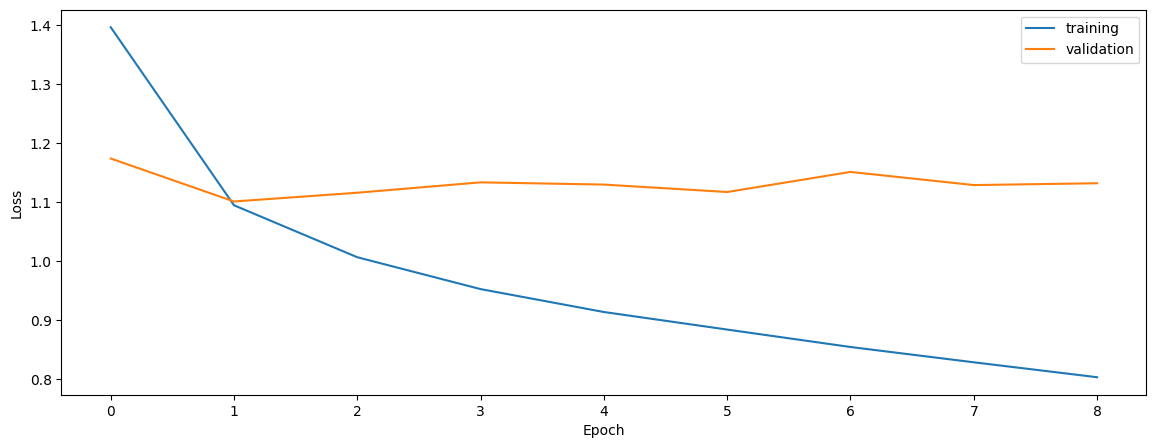

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1068345, 828)
(1068345, 1)
validation
(123115, 828)
(123115, 1)
test
(152076, 828)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_5 (Dense)             (None, 1024)              848896    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/107 [..............................] - ETA: 2:05 - loss: 0.2627 - STD: 8.1317e-05 - MAE: 0.4924

  5/107 [>.............................] - ETA: 1s - loss: 0.2365 - STD: 3.4259e-04 - MAE: 0.4406  

  9/107 [=>............................] - ETA: 1s - loss: 0.2294 - STD: 4.6794e-04 - MAE: 0.4431

 13/107 [==>...........................] - ETA: 1s - loss: 0.2269 - STD: 6.2405e-04 - MAE: 0.4478

 17/107 [===>..........................] - ETA: 1s - loss: 0.2249 - STD: 7.6006e-04 - MAE: 0.4449

 21/107 [====>.........................] - ETA: 1s - loss: 0.2237 - STD: 9.0976e-04 - MAE: 0.4433

 25/107 [======>.......................] - ETA: 1s - loss: 0.2227 - STD: 0.0011 - MAE: 0.4443    

 29/107 [=======>......................] - ETA: 1s - loss: 0.2219 - STD: 0.0013 - MAE: 0.4447

 33/107 [========>.....................] - ETA: 1s - loss: 0.2212 - STD: 0.0016 - MAE: 0.4439

 37/107 [=========>....................] - ETA: 1s - loss: 0.2207 - STD: 0.0020 - MAE: 0.4434

 41/107 [==========>...................] - ETA: 1s - loss: 0.2202 - STD: 0.0025 - MAE: 0.4435

 44/107 [===========>..................] - ETA: 1s - loss: 0.2198 - STD: 0.0031 - MAE: 0.4435

 47/107 [============>.................] - ETA: 1s - loss: 0.2194 - STD: 0.0038 - MAE: 0.4431

 51/107 [=============>................] - ETA: 1s - loss: 0.2189 - STD: 0.0053 - MAE: 0.4427

 55/107 [==============>...............] - ETA: 1s - loss: 0.2182 - STD: 0.0077 - MAE: 0.4421

 59/107 [===============>..............] - ETA: 1s - loss: 0.2173 - STD: 0.0114 - MAE: 0.4409

 63/107 [================>.............] - ETA: 1s - loss: 0.2162 - STD: 0.0166 - MAE: 0.4393

 67/107 [=================>............] - ETA: 0s - loss: 0.2151 - STD: 0.0227 - MAE: 0.4372

 70/107 [==================>...........] - ETA: 0s - loss: 0.2142 - STD: 0.0274 - MAE: 0.4357

 74/107 [===================>..........] - ETA: 0s - loss: 0.2131 - STD: 0.0330 - MAE: 0.4337

 78/107 [====================>.........] - ETA: 0s - loss: 0.2119 - STD: 0.0386 - MAE: 0.4317

 82/107 [=====================>........] - ETA: 0s - loss: 0.2108 - STD: 0.0442 - MAE: 0.4296

 86/107 [=======================>......] - ETA: 0s - loss: 0.2097 - STD: 0.0497 - MAE: 0.4274

 90/107 [========================>.....] - ETA: 0s - loss: 0.2086 - STD: 0.0546 - MAE: 0.4255

 94/107 [=========================>....] - ETA: 0s - loss: 0.2075 - STD: 0.0594 - MAE: 0.4236

 98/107 [==========================>...] - ETA: 0s - loss: 0.2063 - STD: 0.0644 - MAE: 0.4215

102/107 [===========================>..] - ETA: 0s - loss: 0.2051 - STD: 0.0695 - MAE: 0.4192

106/107 [============================>.] - ETA: 0s - loss: 0.2039 - STD: 0.0747 - MAE: 0.4169

107/107 [==============================] - 4s 27ms/step - loss: 0.2036 - STD: 0.0758 - MAE: 0.4163 - val_loss: 0.1616 - val_STD: 0.1857 - val_MAE: 0.3442


Epoch 2/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1725 - STD: 0.2148 - MAE: 0.3557

  4/107 [>.............................] - ETA: 1s - loss: 0.1762 - STD: 0.2088 - MAE: 0.3566

  8/107 [=>............................] - ETA: 1s - loss: 0.1754 - STD: 0.2070 - MAE: 0.3561

 12/107 [==>...........................] - ETA: 1s - loss: 0.1753 - STD: 0.2063 - MAE: 0.3572

 16/107 [===>..........................] - ETA: 1s - loss: 0.1745 - STD: 0.2048 - MAE: 0.3576

 20/107 [====>.........................] - ETA: 1s - loss: 0.1741 - STD: 0.2036 - MAE: 0.3579

 24/107 [=====>........................] - ETA: 1s - loss: 0.1740 - STD: 0.2031 - MAE: 0.3583

 28/107 [======>.......................] - ETA: 1s - loss: 0.1735 - STD: 0.2030 - MAE: 0.3576

 32/107 [=======>......................] - ETA: 1s - loss: 0.1734 - STD: 0.2033 - MAE: 0.3577

 36/107 [=========>....................] - ETA: 1s - loss: 0.1731 - STD: 0.2041 - MAE: 0.3573

 39/107 [=========>....................] - ETA: 1s - loss: 0.1728 - STD: 0.2046 - MAE: 0.3570

 43/107 [===========>..................] - ETA: 1s - loss: 0.1728 - STD: 0.2052 - MAE: 0.3568

 47/107 [============>.................] - ETA: 0s - loss: 0.1724 - STD: 0.2058 - MAE: 0.3563

 51/107 [=============>................] - ETA: 0s - loss: 0.1722 - STD: 0.2064 - MAE: 0.3559

 55/107 [==============>...............] - ETA: 0s - loss: 0.1720 - STD: 0.2071 - MAE: 0.3555

 59/107 [===============>..............] - ETA: 0s - loss: 0.1718 - STD: 0.2077 - MAE: 0.3551

 63/107 [================>.............] - ETA: 0s - loss: 0.1716 - STD: 0.2081 - MAE: 0.3548

 67/107 [=================>............] - ETA: 0s - loss: 0.1714 - STD: 0.2085 - MAE: 0.3546

 71/107 [==================>...........] - ETA: 0s - loss: 0.1713 - STD: 0.2087 - MAE: 0.3543

 75/107 [====================>.........] - ETA: 0s - loss: 0.1710 - STD: 0.2089 - MAE: 0.3540

 79/107 [=====================>........] - ETA: 0s - loss: 0.1709 - STD: 0.2093 - MAE: 0.3538

 83/107 [======================>.......] - ETA: 0s - loss: 0.1708 - STD: 0.2098 - MAE: 0.3535

 87/107 [=======================>......] - ETA: 0s - loss: 0.1706 - STD: 0.2101 - MAE: 0.3532

 91/107 [========================>.....] - ETA: 0s - loss: 0.1706 - STD: 0.2104 - MAE: 0.3531

 95/107 [=========================>....] - ETA: 0s - loss: 0.1705 - STD: 0.2107 - MAE: 0.3529

 99/107 [==========================>...] - ETA: 0s - loss: 0.1703 - STD: 0.2110 - MAE: 0.3526

103/107 [===========================>..] - ETA: 0s - loss: 0.1702 - STD: 0.2111 - MAE: 0.3524

107/107 [==============================] - ETA: 0s - loss: 0.1701 - STD: 0.2114 - MAE: 0.3523

107/107 [==============================] - 2s 18ms/step - loss: 0.1701 - STD: 0.2114 - MAE: 0.3523 - val_loss: 0.1581 - val_STD: 0.1874 - val_MAE: 0.3370


Epoch 3/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1674 - STD: 0.2189 - MAE: 0.3485

  4/107 [>.............................] - ETA: 1s - loss: 0.1679 - STD: 0.2188 - MAE: 0.3482

  8/107 [=>............................] - ETA: 1s - loss: 0.1673 - STD: 0.2196 - MAE: 0.3471

 12/107 [==>...........................] - ETA: 1s - loss: 0.1670 - STD: 0.2200 - MAE: 0.3466

 16/107 [===>..........................] - ETA: 1s - loss: 0.1674 - STD: 0.2200 - MAE: 0.3469

 20/107 [====>.........................] - ETA: 1s - loss: 0.1674 - STD: 0.2196 - MAE: 0.3470

 23/107 [=====>........................] - ETA: 1s - loss: 0.1673 - STD: 0.2195 - MAE: 0.3472

 27/107 [======>.......................] - ETA: 1s - loss: 0.1673 - STD: 0.2195 - MAE: 0.3471

 31/107 [=======>......................] - ETA: 1s - loss: 0.1672 - STD: 0.2200 - MAE: 0.3467

 35/107 [========>.....................] - ETA: 1s - loss: 0.1672 - STD: 0.2203 - MAE: 0.3466

 39/107 [=========>....................] - ETA: 1s - loss: 0.1670 - STD: 0.2200 - MAE: 0.3464

 43/107 [===========>..................] - ETA: 0s - loss: 0.1669 - STD: 0.2202 - MAE: 0.3463

 47/107 [============>.................] - ETA: 0s - loss: 0.1670 - STD: 0.2204 - MAE: 0.3463

 51/107 [=============>................] - ETA: 0s - loss: 0.1669 - STD: 0.2208 - MAE: 0.3460

 55/107 [==============>...............] - ETA: 0s - loss: 0.1668 - STD: 0.2209 - MAE: 0.3458

 59/107 [===============>..............] - ETA: 0s - loss: 0.1669 - STD: 0.2209 - MAE: 0.3459

 63/107 [================>.............] - ETA: 0s - loss: 0.1668 - STD: 0.2207 - MAE: 0.3458

 67/107 [=================>............] - ETA: 0s - loss: 0.1667 - STD: 0.2207 - MAE: 0.3456

 71/107 [==================>...........] - ETA: 0s - loss: 0.1667 - STD: 0.2207 - MAE: 0.3456

 75/107 [====================>.........] - ETA: 0s - loss: 0.1667 - STD: 0.2208 - MAE: 0.3455

 79/107 [=====================>........] - ETA: 0s - loss: 0.1666 - STD: 0.2208 - MAE: 0.3454

 83/107 [======================>.......] - ETA: 0s - loss: 0.1667 - STD: 0.2211 - MAE: 0.3454

 87/107 [=======================>......] - ETA: 0s - loss: 0.1667 - STD: 0.2211 - MAE: 0.3454

 91/107 [========================>.....] - ETA: 0s - loss: 0.1667 - STD: 0.2211 - MAE: 0.3454

 95/107 [=========================>....] - ETA: 0s - loss: 0.1666 - STD: 0.2212 - MAE: 0.3453

 99/107 [==========================>...] - ETA: 0s - loss: 0.1665 - STD: 0.2214 - MAE: 0.3452

103/107 [===========================>..] - ETA: 0s - loss: 0.1665 - STD: 0.2215 - MAE: 0.3451

107/107 [==============================] - ETA: 0s - loss: 0.1665 - STD: 0.2216 - MAE: 0.3451

107/107 [==============================] - 2s 17ms/step - loss: 0.1665 - STD: 0.2216 - MAE: 0.3451 - val_loss: 0.1563 - val_STD: 0.1878 - val_MAE: 0.3298


Epoch 4/10000


  1/107 [..............................] - ETA: 3s - loss: 0.1651 - STD: 0.2236 - MAE: 0.3414

  4/107 [>.............................] - ETA: 1s - loss: 0.1655 - STD: 0.2258 - MAE: 0.3424

  8/107 [=>............................] - ETA: 1s - loss: 0.1644 - STD: 0.2244 - MAE: 0.3412

 12/107 [==>...........................] - ETA: 1s - loss: 0.1643 - STD: 0.2252 - MAE: 0.3410

 16/107 [===>..........................] - ETA: 1s - loss: 0.1642 - STD: 0.2256 - MAE: 0.3410

 20/107 [====>.........................] - ETA: 1s - loss: 0.1646 - STD: 0.2255 - MAE: 0.3413

 24/107 [=====>........................] - ETA: 1s - loss: 0.1645 - STD: 0.2262 - MAE: 0.3411

 28/107 [======>.......................] - ETA: 1s - loss: 0.1645 - STD: 0.2260 - MAE: 0.3411

 32/107 [=======>......................] - ETA: 1s - loss: 0.1646 - STD: 0.2261 - MAE: 0.3413

 36/107 [=========>....................] - ETA: 1s - loss: 0.1645 - STD: 0.2263 - MAE: 0.3411

 40/107 [==========>...................] - ETA: 1s - loss: 0.1644 - STD: 0.2261 - MAE: 0.3411

 44/107 [===========>..................] - ETA: 0s - loss: 0.1648 - STD: 0.2262 - MAE: 0.3413

 48/107 [============>.................] - ETA: 0s - loss: 0.1653 - STD: 0.2259 - MAE: 0.3414

 52/107 [=============>................] - ETA: 0s - loss: 0.1654 - STD: 0.2252 - MAE: 0.3416

 56/107 [==============>...............] - ETA: 0s - loss: 0.1655 - STD: 0.2242 - MAE: 0.3420

 60/107 [===============>..............] - ETA: 0s - loss: 0.1656 - STD: 0.2236 - MAE: 0.3423

 64/107 [================>.............] - ETA: 0s - loss: 0.1656 - STD: 0.2235 - MAE: 0.3424

 68/107 [==================>...........] - ETA: 0s - loss: 0.1656 - STD: 0.2236 - MAE: 0.3424

 72/107 [===================>..........] - ETA: 0s - loss: 0.1657 - STD: 0.2236 - MAE: 0.3424

 76/107 [====================>.........] - ETA: 0s - loss: 0.1656 - STD: 0.2237 - MAE: 0.3423

 80/107 [=====================>........] - ETA: 0s - loss: 0.1656 - STD: 0.2237 - MAE: 0.3424

 84/107 [======================>.......] - ETA: 0s - loss: 0.1655 - STD: 0.2239 - MAE: 0.3423

 88/107 [=======================>......] - ETA: 0s - loss: 0.1654 - STD: 0.2240 - MAE: 0.3422

 92/107 [========================>.....] - ETA: 0s - loss: 0.1653 - STD: 0.2241 - MAE: 0.3421

 96/107 [=========================>....] - ETA: 0s - loss: 0.1653 - STD: 0.2242 - MAE: 0.3420

100/107 [===========================>..] - ETA: 0s - loss: 0.1652 - STD: 0.2244 - MAE: 0.3419

104/107 [============================>.] - ETA: 0s - loss: 0.1652 - STD: 0.2246 - MAE: 0.3418

107/107 [==============================] - 2s 17ms/step - loss: 0.1651 - STD: 0.2246 - MAE: 0.3417 - val_loss: 0.1538 - val_STD: 0.1924 - val_MAE: 0.3294


Epoch 5/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1663 - STD: 0.2280 - MAE: 0.3439

  5/107 [>.............................] - ETA: 1s - loss: 0.1640 - STD: 0.2264 - MAE: 0.3414

  9/107 [=>............................] - ETA: 1s - loss: 0.1636 - STD: 0.2272 - MAE: 0.3404

 13/107 [==>...........................] - ETA: 1s - loss: 0.1640 - STD: 0.2281 - MAE: 0.3404

 17/107 [===>..........................] - ETA: 1s - loss: 0.1635 - STD: 0.2282 - MAE: 0.3397

 21/107 [====>.........................] - ETA: 1s - loss: 0.1635 - STD: 0.2282 - MAE: 0.3394

 25/107 [======>.......................] - ETA: 1s - loss: 0.1633 - STD: 0.2287 - MAE: 0.3390

 29/107 [=======>......................] - ETA: 1s - loss: 0.1632 - STD: 0.2287 - MAE: 0.3388

 33/107 [========>.....................] - ETA: 1s - loss: 0.1630 - STD: 0.2288 - MAE: 0.3387

 37/107 [=========>....................] - ETA: 1s - loss: 0.1630 - STD: 0.2290 - MAE: 0.3386

 41/107 [==========>...................] - ETA: 1s - loss: 0.1631 - STD: 0.2293 - MAE: 0.3386

 45/107 [===========>..................] - ETA: 0s - loss: 0.1630 - STD: 0.2296 - MAE: 0.3384

 49/107 [============>.................] - ETA: 0s - loss: 0.1631 - STD: 0.2296 - MAE: 0.3383

 53/107 [=============>................] - ETA: 0s - loss: 0.1630 - STD: 0.2295 - MAE: 0.3381

 57/107 [==============>...............] - ETA: 0s - loss: 0.1629 - STD: 0.2298 - MAE: 0.3380

 61/107 [================>.............] - ETA: 0s - loss: 0.1629 - STD: 0.2298 - MAE: 0.3379

 65/107 [=================>............] - ETA: 0s - loss: 0.1629 - STD: 0.2296 - MAE: 0.3379

 69/107 [==================>...........] - ETA: 0s - loss: 0.1630 - STD: 0.2297 - MAE: 0.3380

 73/107 [===================>..........] - ETA: 0s - loss: 0.1629 - STD: 0.2299 - MAE: 0.3379

 77/107 [====================>.........] - ETA: 0s - loss: 0.1629 - STD: 0.2299 - MAE: 0.3377

 81/107 [=====================>........] - ETA: 0s - loss: 0.1629 - STD: 0.2297 - MAE: 0.3378

 85/107 [======================>.......] - ETA: 0s - loss: 0.1628 - STD: 0.2298 - MAE: 0.3378

 89/107 [=======================>......] - ETA: 0s - loss: 0.1628 - STD: 0.2298 - MAE: 0.3377

 93/107 [=========================>....] - ETA: 0s - loss: 0.1627 - STD: 0.2299 - MAE: 0.3376

 97/107 [==========================>...] - ETA: 0s - loss: 0.1626 - STD: 0.2300 - MAE: 0.3374

101/107 [===========================>..] - ETA: 0s - loss: 0.1625 - STD: 0.2303 - MAE: 0.3373

105/107 [============================>.] - ETA: 0s - loss: 0.1625 - STD: 0.2305 - MAE: 0.3371

107/107 [==============================] - 2s 18ms/step - loss: 0.1625 - STD: 0.2306 - MAE: 0.3371 - val_loss: 0.1537 - val_STD: 0.1932 - val_MAE: 0.3228


Epoch 6/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1636 - STD: 0.2284 - MAE: 0.3363

  4/107 [>.............................] - ETA: 1s - loss: 0.1612 - STD: 0.2334 - MAE: 0.3347

  8/107 [=>............................] - ETA: 1s - loss: 0.1612 - STD: 0.2339 - MAE: 0.3347

 12/107 [==>...........................] - ETA: 1s - loss: 0.1607 - STD: 0.2335 - MAE: 0.3343

 16/107 [===>..........................] - ETA: 1s - loss: 0.1606 - STD: 0.2345 - MAE: 0.3336

 19/107 [====>.........................] - ETA: 1s - loss: 0.1610 - STD: 0.2342 - MAE: 0.3343

 23/107 [=====>........................] - ETA: 1s - loss: 0.1611 - STD: 0.2341 - MAE: 0.3343

 27/107 [======>.......................] - ETA: 1s - loss: 0.1610 - STD: 0.2346 - MAE: 0.3340

 31/107 [=======>......................] - ETA: 1s - loss: 0.1609 - STD: 0.2341 - MAE: 0.3342

 35/107 [========>.....................] - ETA: 1s - loss: 0.1608 - STD: 0.2342 - MAE: 0.3338

 39/107 [=========>....................] - ETA: 1s - loss: 0.1609 - STD: 0.2345 - MAE: 0.3337

 43/107 [===========>..................] - ETA: 0s - loss: 0.1610 - STD: 0.2340 - MAE: 0.3341

 47/107 [============>.................] - ETA: 0s - loss: 0.1613 - STD: 0.2336 - MAE: 0.3342

 51/107 [=============>................] - ETA: 0s - loss: 0.1613 - STD: 0.2338 - MAE: 0.3342

 55/107 [==============>...............] - ETA: 0s - loss: 0.1613 - STD: 0.2336 - MAE: 0.3343

 59/107 [===============>..............] - ETA: 0s - loss: 0.1612 - STD: 0.2333 - MAE: 0.3344

 63/107 [================>.............] - ETA: 0s - loss: 0.1612 - STD: 0.2334 - MAE: 0.3344

 67/107 [=================>............] - ETA: 0s - loss: 0.1612 - STD: 0.2335 - MAE: 0.3343

 71/107 [==================>...........] - ETA: 0s - loss: 0.1612 - STD: 0.2333 - MAE: 0.3344

 75/107 [====================>.........] - ETA: 0s - loss: 0.1613 - STD: 0.2332 - MAE: 0.3344

 79/107 [=====================>........] - ETA: 0s - loss: 0.1613 - STD: 0.2333 - MAE: 0.3343

 83/107 [======================>.......] - ETA: 0s - loss: 0.1615 - STD: 0.2333 - MAE: 0.3345

 87/107 [=======================>......] - ETA: 0s - loss: 0.1615 - STD: 0.2332 - MAE: 0.3346

 91/107 [========================>.....] - ETA: 0s - loss: 0.1614 - STD: 0.2331 - MAE: 0.3345

 95/107 [=========================>....] - ETA: 0s - loss: 0.1613 - STD: 0.2330 - MAE: 0.3345

 99/107 [==========================>...] - ETA: 0s - loss: 0.1613 - STD: 0.2333 - MAE: 0.3344

103/107 [===========================>..] - ETA: 0s - loss: 0.1612 - STD: 0.2334 - MAE: 0.3342

107/107 [==============================] - ETA: 0s - loss: 0.1612 - STD: 0.2335 - MAE: 0.3342

107/107 [==============================] - 2s 17ms/step - loss: 0.1612 - STD: 0.2335 - MAE: 0.3342 - val_loss: 0.1510 - val_STD: 0.1998 - val_MAE: 0.3215


Epoch 7/10000


  1/107 [..............................] - ETA: 3s - loss: 0.1567 - STD: 0.2402 - MAE: 0.3282

  4/107 [>.............................] - ETA: 2s - loss: 0.1596 - STD: 0.2365 - MAE: 0.3321

  8/107 [=>............................] - ETA: 1s - loss: 0.1607 - STD: 0.2339 - MAE: 0.3329

 12/107 [==>...........................] - ETA: 1s - loss: 0.1613 - STD: 0.2345 - MAE: 0.3334

 16/107 [===>..........................] - ETA: 1s - loss: 0.1609 - STD: 0.2343 - MAE: 0.3336

 20/107 [====>.........................] - ETA: 1s - loss: 0.1607 - STD: 0.2344 - MAE: 0.3333

 24/107 [=====>........................] - ETA: 1s - loss: 0.1604 - STD: 0.2349 - MAE: 0.3326

 28/107 [======>.......................] - ETA: 1s - loss: 0.1612 - STD: 0.2353 - MAE: 0.3330

 32/107 [=======>......................] - ETA: 1s - loss: 0.1617 - STD: 0.2343 - MAE: 0.3334

 36/107 [=========>....................] - ETA: 1s - loss: 0.1618 - STD: 0.2331 - MAE: 0.3338

 40/107 [==========>...................] - ETA: 1s - loss: 0.1616 - STD: 0.2324 - MAE: 0.3341

 44/107 [===========>..................] - ETA: 0s - loss: 0.1614 - STD: 0.2323 - MAE: 0.3340

 48/107 [============>.................] - ETA: 0s - loss: 0.1612 - STD: 0.2329 - MAE: 0.3336

 51/107 [=============>................] - ETA: 0s - loss: 0.1610 - STD: 0.2331 - MAE: 0.3334

 55/107 [==============>...............] - ETA: 0s - loss: 0.1610 - STD: 0.2334 - MAE: 0.3333

 59/107 [===============>..............] - ETA: 0s - loss: 0.1610 - STD: 0.2333 - MAE: 0.3333

 63/107 [================>.............] - ETA: 0s - loss: 0.1609 - STD: 0.2333 - MAE: 0.3333

 67/107 [=================>............] - ETA: 0s - loss: 0.1608 - STD: 0.2336 - MAE: 0.3331

 71/107 [==================>...........] - ETA: 0s - loss: 0.1607 - STD: 0.2339 - MAE: 0.3329

 75/107 [====================>.........] - ETA: 0s - loss: 0.1606 - STD: 0.2341 - MAE: 0.3328

 79/107 [=====================>........] - ETA: 0s - loss: 0.1606 - STD: 0.2343 - MAE: 0.3327

 83/107 [======================>.......] - ETA: 0s - loss: 0.1604 - STD: 0.2344 - MAE: 0.3326

 87/107 [=======================>......] - ETA: 0s - loss: 0.1604 - STD: 0.2346 - MAE: 0.3324

 91/107 [========================>.....] - ETA: 0s - loss: 0.1604 - STD: 0.2347 - MAE: 0.3324

 95/107 [=========================>....] - ETA: 0s - loss: 0.1603 - STD: 0.2348 - MAE: 0.3323

 99/107 [==========================>...] - ETA: 0s - loss: 0.1604 - STD: 0.2350 - MAE: 0.3323

103/107 [===========================>..] - ETA: 0s - loss: 0.1605 - STD: 0.2349 - MAE: 0.3323

107/107 [==============================] - ETA: 0s - loss: 0.1605 - STD: 0.2349 - MAE: 0.3323

107/107 [==============================] - 2s 18ms/step - loss: 0.1605 - STD: 0.2349 - MAE: 0.3323 - val_loss: 0.1507 - val_STD: 0.1968 - val_MAE: 0.3213


Epoch 8/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1568 - STD: 0.2364 - MAE: 0.3289

  5/107 [>.............................] - ETA: 1s - loss: 0.1582 - STD: 0.2322 - MAE: 0.3329

  9/107 [=>............................] - ETA: 1s - loss: 0.1583 - STD: 0.2348 - MAE: 0.3315

 13/107 [==>...........................] - ETA: 1s - loss: 0.1577 - STD: 0.2374 - MAE: 0.3296

 17/107 [===>..........................] - ETA: 1s - loss: 0.1579 - STD: 0.2369 - MAE: 0.3297

 21/107 [====>.........................] - ETA: 1s - loss: 0.1582 - STD: 0.2373 - MAE: 0.3299

 25/107 [======>.......................] - ETA: 1s - loss: 0.1581 - STD: 0.2379 - MAE: 0.3296

 29/107 [=======>......................] - ETA: 1s - loss: 0.1580 - STD: 0.2380 - MAE: 0.3294

 33/107 [========>.....................] - ETA: 1s - loss: 0.1581 - STD: 0.2381 - MAE: 0.3295

 37/107 [=========>....................] - ETA: 1s - loss: 0.1581 - STD: 0.2385 - MAE: 0.3293

 41/107 [==========>...................] - ETA: 1s - loss: 0.1581 - STD: 0.2387 - MAE: 0.3292

 45/107 [===========>..................] - ETA: 0s - loss: 0.1581 - STD: 0.2387 - MAE: 0.3292

 49/107 [============>.................] - ETA: 0s - loss: 0.1580 - STD: 0.2390 - MAE: 0.3291

 53/107 [=============>................] - ETA: 0s - loss: 0.1581 - STD: 0.2393 - MAE: 0.3288

 57/107 [==============>...............] - ETA: 0s - loss: 0.1584 - STD: 0.2389 - MAE: 0.3291

 61/107 [================>.............] - ETA: 0s - loss: 0.1590 - STD: 0.2385 - MAE: 0.3297

 65/107 [=================>............] - ETA: 0s - loss: 0.1592 - STD: 0.2382 - MAE: 0.3300

 69/107 [==================>...........] - ETA: 0s - loss: 0.1593 - STD: 0.2376 - MAE: 0.3301

 73/107 [===================>..........] - ETA: 0s - loss: 0.1593 - STD: 0.2375 - MAE: 0.3301

 77/107 [====================>.........] - ETA: 0s - loss: 0.1593 - STD: 0.2371 - MAE: 0.3302

 80/107 [=====================>........] - ETA: 0s - loss: 0.1593 - STD: 0.2367 - MAE: 0.3304

 84/107 [======================>.......] - ETA: 0s - loss: 0.1594 - STD: 0.2368 - MAE: 0.3304

 88/107 [=======================>......] - ETA: 0s - loss: 0.1594 - STD: 0.2368 - MAE: 0.3304

 92/107 [========================>.....] - ETA: 0s - loss: 0.1594 - STD: 0.2367 - MAE: 0.3304

 96/107 [=========================>....] - ETA: 0s - loss: 0.1592 - STD: 0.2368 - MAE: 0.3303

100/107 [===========================>..] - ETA: 0s - loss: 0.1592 - STD: 0.2370 - MAE: 0.3303

104/107 [============================>.] - ETA: 0s - loss: 0.1592 - STD: 0.2371 - MAE: 0.3302

107/107 [==============================] - 2s 17ms/step - loss: 0.1591 - STD: 0.2373 - MAE: 0.3301 - val_loss: 0.1502 - val_STD: 0.2012 - val_MAE: 0.3163


Epoch 9/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1589 - STD: 0.2362 - MAE: 0.3281

  5/107 [>.............................] - ETA: 1s - loss: 0.1579 - STD: 0.2392 - MAE: 0.3279

  9/107 [=>............................] - ETA: 1s - loss: 0.1575 - STD: 0.2394 - MAE: 0.3277

 13/107 [==>...........................] - ETA: 1s - loss: 0.1575 - STD: 0.2409 - MAE: 0.3273

 17/107 [===>..........................] - ETA: 1s - loss: 0.1569 - STD: 0.2405 - MAE: 0.3269

 21/107 [====>.........................] - ETA: 1s - loss: 0.1567 - STD: 0.2412 - MAE: 0.3262

 25/107 [======>.......................] - ETA: 1s - loss: 0.1570 - STD: 0.2418 - MAE: 0.3263

 29/107 [=======>......................] - ETA: 1s - loss: 0.1570 - STD: 0.2417 - MAE: 0.3265

 33/107 [========>.....................] - ETA: 1s - loss: 0.1570 - STD: 0.2417 - MAE: 0.3264

 37/107 [=========>....................] - ETA: 1s - loss: 0.1569 - STD: 0.2415 - MAE: 0.3264

 41/107 [==========>...................] - ETA: 0s - loss: 0.1571 - STD: 0.2418 - MAE: 0.3265

 45/107 [===========>..................] - ETA: 0s - loss: 0.1572 - STD: 0.2420 - MAE: 0.3263

 49/107 [============>.................] - ETA: 0s - loss: 0.1574 - STD: 0.2413 - MAE: 0.3268

 53/107 [=============>................] - ETA: 0s - loss: 0.1574 - STD: 0.2412 - MAE: 0.3268

 57/107 [==============>...............] - ETA: 0s - loss: 0.1573 - STD: 0.2415 - MAE: 0.3266

 61/107 [================>.............] - ETA: 0s - loss: 0.1574 - STD: 0.2412 - MAE: 0.3269

 65/107 [=================>............] - ETA: 0s - loss: 0.1573 - STD: 0.2413 - MAE: 0.3268

 69/107 [==================>...........] - ETA: 0s - loss: 0.1572 - STD: 0.2416 - MAE: 0.3266

 73/107 [===================>..........] - ETA: 0s - loss: 0.1572 - STD: 0.2417 - MAE: 0.3266

 77/107 [====================>.........] - ETA: 0s - loss: 0.1571 - STD: 0.2417 - MAE: 0.3265

 81/107 [=====================>........] - ETA: 0s - loss: 0.1572 - STD: 0.2417 - MAE: 0.3266

 85/107 [======================>.......] - ETA: 0s - loss: 0.1571 - STD: 0.2417 - MAE: 0.3265

 89/107 [=======================>......] - ETA: 0s - loss: 0.1570 - STD: 0.2419 - MAE: 0.3263

 93/107 [=========================>....] - ETA: 0s - loss: 0.1570 - STD: 0.2420 - MAE: 0.3263

 97/107 [==========================>...] - ETA: 0s - loss: 0.1570 - STD: 0.2422 - MAE: 0.3263

101/107 [===========================>..] - ETA: 0s - loss: 0.1570 - STD: 0.2423 - MAE: 0.3262

105/107 [============================>.] - ETA: 0s - loss: 0.1571 - STD: 0.2422 - MAE: 0.3263

107/107 [==============================] - 2s 17ms/step - loss: 0.1572 - STD: 0.2422 - MAE: 0.3262 - val_loss: 0.1504 - val_STD: 0.2008 - val_MAE: 0.3144


Epoch 10/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1559 - STD: 0.2395 - MAE: 0.3224

  5/107 [>.............................] - ETA: 1s - loss: 0.1601 - STD: 0.2397 - MAE: 0.3297

  9/107 [=>............................] - ETA: 1s - loss: 0.1590 - STD: 0.2389 - MAE: 0.3294

 13/107 [==>...........................] - ETA: 1s - loss: 0.1590 - STD: 0.2381 - MAE: 0.3287

 17/107 [===>..........................] - ETA: 1s - loss: 0.1588 - STD: 0.2386 - MAE: 0.3281

 21/107 [====>.........................] - ETA: 1s - loss: 0.1582 - STD: 0.2386 - MAE: 0.3277

 25/107 [======>.......................] - ETA: 1s - loss: 0.1580 - STD: 0.2392 - MAE: 0.3274

 29/107 [=======>......................] - ETA: 1s - loss: 0.1578 - STD: 0.2400 - MAE: 0.3270

 33/107 [========>.....................] - ETA: 1s - loss: 0.1575 - STD: 0.2401 - MAE: 0.3269

 37/107 [=========>....................] - ETA: 1s - loss: 0.1574 - STD: 0.2406 - MAE: 0.3266

 41/107 [==========>...................] - ETA: 1s - loss: 0.1573 - STD: 0.2410 - MAE: 0.3264

 45/107 [===========>..................] - ETA: 0s - loss: 0.1573 - STD: 0.2411 - MAE: 0.3264

 49/107 [============>.................] - ETA: 0s - loss: 0.1570 - STD: 0.2415 - MAE: 0.3261

 53/107 [=============>................] - ETA: 0s - loss: 0.1569 - STD: 0.2418 - MAE: 0.3258

 57/107 [==============>...............] - ETA: 0s - loss: 0.1568 - STD: 0.2420 - MAE: 0.3257

 61/107 [================>.............] - ETA: 0s - loss: 0.1567 - STD: 0.2421 - MAE: 0.3256

 65/107 [=================>............] - ETA: 0s - loss: 0.1565 - STD: 0.2424 - MAE: 0.3253

 69/107 [==================>...........] - ETA: 0s - loss: 0.1565 - STD: 0.2425 - MAE: 0.3253

 73/107 [===================>..........] - ETA: 0s - loss: 0.1565 - STD: 0.2426 - MAE: 0.3252

 77/107 [====================>.........] - ETA: 0s - loss: 0.1565 - STD: 0.2428 - MAE: 0.3251

 81/107 [=====================>........] - ETA: 0s - loss: 0.1564 - STD: 0.2430 - MAE: 0.3250

 85/107 [======================>.......] - ETA: 0s - loss: 0.1564 - STD: 0.2432 - MAE: 0.3249

 89/107 [=======================>......] - ETA: 0s - loss: 0.1564 - STD: 0.2433 - MAE: 0.3249

 93/107 [=========================>....] - ETA: 0s - loss: 0.1563 - STD: 0.2435 - MAE: 0.3247

 97/107 [==========================>...] - ETA: 0s - loss: 0.1562 - STD: 0.2436 - MAE: 0.3247

101/107 [===========================>..] - ETA: 0s - loss: 0.1562 - STD: 0.2438 - MAE: 0.3246

105/107 [============================>.] - ETA: 0s - loss: 0.1561 - STD: 0.2439 - MAE: 0.3245

107/107 [==============================] - 2s 17ms/step - loss: 0.1560 - STD: 0.2440 - MAE: 0.3244 - val_loss: 0.1482 - val_STD: 0.2066 - val_MAE: 0.3110


Epoch 11/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1536 - STD: 0.2455 - MAE: 0.3188

  4/107 [>.............................] - ETA: 1s - loss: 0.1562 - STD: 0.2444 - MAE: 0.3228

  8/107 [=>............................] - ETA: 1s - loss: 0.1600 - STD: 0.2467 - MAE: 0.3263

 12/107 [==>...........................] - ETA: 1s - loss: 0.1635 - STD: 0.2418 - MAE: 0.3288

 16/107 [===>..........................] - ETA: 1s - loss: 0.1641 - STD: 0.2385 - MAE: 0.3302

 20/107 [====>.........................] - ETA: 1s - loss: 0.1637 - STD: 0.2369 - MAE: 0.3306

 24/107 [=====>........................] - ETA: 1s - loss: 0.1633 - STD: 0.2359 - MAE: 0.3310

 28/107 [======>.......................] - ETA: 1s - loss: 0.1627 - STD: 0.2348 - MAE: 0.3311

 32/107 [=======>......................] - ETA: 1s - loss: 0.1620 - STD: 0.2347 - MAE: 0.3308

 36/107 [=========>....................] - ETA: 1s - loss: 0.1613 - STD: 0.2351 - MAE: 0.3304

 40/107 [==========>...................] - ETA: 1s - loss: 0.1609 - STD: 0.2353 - MAE: 0.3302

 44/107 [===========>..................] - ETA: 0s - loss: 0.1605 - STD: 0.2359 - MAE: 0.3298

 48/107 [============>.................] - ETA: 0s - loss: 0.1599 - STD: 0.2368 - MAE: 0.3292

 52/107 [=============>................] - ETA: 0s - loss: 0.1596 - STD: 0.2374 - MAE: 0.3288

 56/107 [==============>...............] - ETA: 0s - loss: 0.1592 - STD: 0.2381 - MAE: 0.3283

 60/107 [===============>..............] - ETA: 0s - loss: 0.1590 - STD: 0.2389 - MAE: 0.3277

 64/107 [================>.............] - ETA: 0s - loss: 0.1587 - STD: 0.2394 - MAE: 0.3274

 68/107 [==================>...........] - ETA: 0s - loss: 0.1584 - STD: 0.2398 - MAE: 0.3270

 72/107 [===================>..........] - ETA: 0s - loss: 0.1582 - STD: 0.2403 - MAE: 0.3266

 76/107 [====================>.........] - ETA: 0s - loss: 0.1581 - STD: 0.2404 - MAE: 0.3265

 80/107 [=====================>........] - ETA: 0s - loss: 0.1580 - STD: 0.2407 - MAE: 0.3264

 83/107 [======================>.......] - ETA: 0s - loss: 0.1579 - STD: 0.2408 - MAE: 0.3263

 87/107 [=======================>......] - ETA: 0s - loss: 0.1578 - STD: 0.2409 - MAE: 0.3262

 91/107 [========================>.....] - ETA: 0s - loss: 0.1576 - STD: 0.2411 - MAE: 0.3261

 95/107 [=========================>....] - ETA: 0s - loss: 0.1575 - STD: 0.2414 - MAE: 0.3258

 99/107 [==========================>...] - ETA: 0s - loss: 0.1573 - STD: 0.2416 - MAE: 0.3256

103/107 [===========================>..] - ETA: 0s - loss: 0.1571 - STD: 0.2420 - MAE: 0.3253

107/107 [==============================] - ETA: 0s - loss: 0.1570 - STD: 0.2423 - MAE: 0.3251

107/107 [==============================] - 2s 18ms/step - loss: 0.1570 - STD: 0.2423 - MAE: 0.3251 - val_loss: 0.1470 - val_STD: 0.2080 - val_MAE: 0.3132


Epoch 12/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1545 - STD: 0.2456 - MAE: 0.3223

  5/107 [>.............................] - ETA: 1s - loss: 0.1544 - STD: 0.2480 - MAE: 0.3222

  9/107 [=>............................] - ETA: 1s - loss: 0.1556 - STD: 0.2467 - MAE: 0.3225

 13/107 [==>...........................] - ETA: 1s - loss: 0.1555 - STD: 0.2455 - MAE: 0.3228

 17/107 [===>..........................] - ETA: 1s - loss: 0.1549 - STD: 0.2464 - MAE: 0.3220

 21/107 [====>.........................] - ETA: 1s - loss: 0.1543 - STD: 0.2475 - MAE: 0.3211

 25/107 [======>.......................] - ETA: 1s - loss: 0.1543 - STD: 0.2472 - MAE: 0.3213

 29/107 [=======>......................] - ETA: 1s - loss: 0.1545 - STD: 0.2472 - MAE: 0.3213

 33/107 [========>.....................] - ETA: 1s - loss: 0.1543 - STD: 0.2477 - MAE: 0.3209

 37/107 [=========>....................] - ETA: 1s - loss: 0.1544 - STD: 0.2475 - MAE: 0.3212

 41/107 [==========>...................] - ETA: 1s - loss: 0.1542 - STD: 0.2475 - MAE: 0.3210

 45/107 [===========>..................] - ETA: 0s - loss: 0.1542 - STD: 0.2477 - MAE: 0.3210

 49/107 [============>.................] - ETA: 0s - loss: 0.1541 - STD: 0.2480 - MAE: 0.3208

 53/107 [=============>................] - ETA: 0s - loss: 0.1540 - STD: 0.2482 - MAE: 0.3206

 57/107 [==============>...............] - ETA: 0s - loss: 0.1539 - STD: 0.2483 - MAE: 0.3205

 61/107 [================>.............] - ETA: 0s - loss: 0.1539 - STD: 0.2485 - MAE: 0.3204

 65/107 [=================>............] - ETA: 0s - loss: 0.1539 - STD: 0.2483 - MAE: 0.3205

 69/107 [==================>...........] - ETA: 0s - loss: 0.1539 - STD: 0.2484 - MAE: 0.3205

 73/107 [===================>..........] - ETA: 0s - loss: 0.1540 - STD: 0.2485 - MAE: 0.3205

 77/107 [====================>.........] - ETA: 0s - loss: 0.1539 - STD: 0.2486 - MAE: 0.3205

 81/107 [=====================>........] - ETA: 0s - loss: 0.1540 - STD: 0.2485 - MAE: 0.3206

 85/107 [======================>.......] - ETA: 0s - loss: 0.1540 - STD: 0.2487 - MAE: 0.3205

 89/107 [=======================>......] - ETA: 0s - loss: 0.1539 - STD: 0.2487 - MAE: 0.3204

 93/107 [=========================>....] - ETA: 0s - loss: 0.1539 - STD: 0.2487 - MAE: 0.3203

 97/107 [==========================>...] - ETA: 0s - loss: 0.1538 - STD: 0.2487 - MAE: 0.3202

101/107 [===========================>..] - ETA: 0s - loss: 0.1537 - STD: 0.2490 - MAE: 0.3201

105/107 [============================>.] - ETA: 0s - loss: 0.1537 - STD: 0.2491 - MAE: 0.3199

107/107 [==============================] - 2s 17ms/step - loss: 0.1536 - STD: 0.2491 - MAE: 0.3199 - val_loss: 0.1454 - val_STD: 0.2177 - val_MAE: 0.3135


Epoch 13/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1522 - STD: 0.2524 - MAE: 0.3206

  5/107 [>.............................] - ETA: 1s - loss: 0.1554 - STD: 0.2538 - MAE: 0.3194

  9/107 [=>............................] - ETA: 1s - loss: 0.1541 - STD: 0.2513 - MAE: 0.3188

 13/107 [==>...........................] - ETA: 1s - loss: 0.1535 - STD: 0.2523 - MAE: 0.3183

 17/107 [===>..........................] - ETA: 1s - loss: 0.1540 - STD: 0.2504 - MAE: 0.3195

 21/107 [====>.........................] - ETA: 1s - loss: 0.1540 - STD: 0.2508 - MAE: 0.3193

 25/107 [======>.......................] - ETA: 1s - loss: 0.1538 - STD: 0.2503 - MAE: 0.3192

 29/107 [=======>......................] - ETA: 1s - loss: 0.1542 - STD: 0.2505 - MAE: 0.3197

 33/107 [========>.....................] - ETA: 1s - loss: 0.1545 - STD: 0.2493 - MAE: 0.3199

 37/107 [=========>....................] - ETA: 1s - loss: 0.1553 - STD: 0.2488 - MAE: 0.3203

 41/107 [==========>...................] - ETA: 1s - loss: 0.1564 - STD: 0.2478 - MAE: 0.3215

 45/107 [===========>..................] - ETA: 0s - loss: 0.1564 - STD: 0.2472 - MAE: 0.3218

 49/107 [============>.................] - ETA: 0s - loss: 0.1563 - STD: 0.2463 - MAE: 0.3221

 53/107 [=============>................] - ETA: 0s - loss: 0.1561 - STD: 0.2459 - MAE: 0.3221

 57/107 [==============>...............] - ETA: 0s - loss: 0.1558 - STD: 0.2460 - MAE: 0.3219

 61/107 [================>.............] - ETA: 0s - loss: 0.1556 - STD: 0.2458 - MAE: 0.3219

 65/107 [=================>............] - ETA: 0s - loss: 0.1554 - STD: 0.2459 - MAE: 0.3218

 69/107 [==================>...........] - ETA: 0s - loss: 0.1554 - STD: 0.2461 - MAE: 0.3218

 73/107 [===================>..........] - ETA: 0s - loss: 0.1553 - STD: 0.2461 - MAE: 0.3218

 77/107 [====================>.........] - ETA: 0s - loss: 0.1552 - STD: 0.2465 - MAE: 0.3216

 81/107 [=====================>........] - ETA: 0s - loss: 0.1551 - STD: 0.2466 - MAE: 0.3214

 85/107 [======================>.......] - ETA: 0s - loss: 0.1551 - STD: 0.2465 - MAE: 0.3214

 89/107 [=======================>......] - ETA: 0s - loss: 0.1550 - STD: 0.2468 - MAE: 0.3212

 93/107 [=========================>....] - ETA: 0s - loss: 0.1549 - STD: 0.2469 - MAE: 0.3211

 97/107 [==========================>...] - ETA: 0s - loss: 0.1548 - STD: 0.2470 - MAE: 0.3210

101/107 [===========================>..] - ETA: 0s - loss: 0.1548 - STD: 0.2471 - MAE: 0.3210

105/107 [============================>.] - ETA: 0s - loss: 0.1547 - STD: 0.2471 - MAE: 0.3209

107/107 [==============================] - 2s 17ms/step - loss: 0.1546 - STD: 0.2472 - MAE: 0.3208 - val_loss: 0.1466 - val_STD: 0.2058 - val_MAE: 0.3075


Epoch 14/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1511 - STD: 0.2478 - MAE: 0.3161

  5/107 [>.............................] - ETA: 1s - loss: 0.1516 - STD: 0.2506 - MAE: 0.3166

  9/107 [=>............................] - ETA: 1s - loss: 0.1518 - STD: 0.2518 - MAE: 0.3167

 13/107 [==>...........................] - ETA: 1s - loss: 0.1519 - STD: 0.2514 - MAE: 0.3173

 17/107 [===>..........................] - ETA: 1s - loss: 0.1521 - STD: 0.2510 - MAE: 0.3172

 21/107 [====>.........................] - ETA: 1s - loss: 0.1520 - STD: 0.2512 - MAE: 0.3171

 25/107 [======>.......................] - ETA: 1s - loss: 0.1518 - STD: 0.2517 - MAE: 0.3169

 29/107 [=======>......................] - ETA: 1s - loss: 0.1516 - STD: 0.2519 - MAE: 0.3165

 33/107 [========>.....................] - ETA: 1s - loss: 0.1515 - STD: 0.2517 - MAE: 0.3165

 37/107 [=========>....................] - ETA: 1s - loss: 0.1514 - STD: 0.2523 - MAE: 0.3161

 41/107 [==========>...................] - ETA: 1s - loss: 0.1515 - STD: 0.2525 - MAE: 0.3163

 45/107 [===========>..................] - ETA: 0s - loss: 0.1518 - STD: 0.2524 - MAE: 0.3165

 49/107 [============>.................] - ETA: 0s - loss: 0.1521 - STD: 0.2524 - MAE: 0.3166

 53/107 [=============>................] - ETA: 0s - loss: 0.1531 - STD: 0.2519 - MAE: 0.3176

 57/107 [==============>...............] - ETA: 0s - loss: 0.1536 - STD: 0.2513 - MAE: 0.3179

 61/107 [================>.............] - ETA: 0s - loss: 0.1539 - STD: 0.2506 - MAE: 0.3184

 65/107 [=================>............] - ETA: 0s - loss: 0.1541 - STD: 0.2498 - MAE: 0.3187

 69/107 [==================>...........] - ETA: 0s - loss: 0.1541 - STD: 0.2492 - MAE: 0.3191

 73/107 [===================>..........] - ETA: 0s - loss: 0.1542 - STD: 0.2489 - MAE: 0.3193

 77/107 [====================>.........] - ETA: 0s - loss: 0.1542 - STD: 0.2485 - MAE: 0.3195

 81/107 [=====================>........] - ETA: 0s - loss: 0.1541 - STD: 0.2484 - MAE: 0.3196

 85/107 [======================>.......] - ETA: 0s - loss: 0.1541 - STD: 0.2483 - MAE: 0.3196

 89/107 [=======================>......] - ETA: 0s - loss: 0.1540 - STD: 0.2484 - MAE: 0.3195

 93/107 [=========================>....] - ETA: 0s - loss: 0.1539 - STD: 0.2484 - MAE: 0.3194

 97/107 [==========================>...] - ETA: 0s - loss: 0.1539 - STD: 0.2486 - MAE: 0.3193

101/107 [===========================>..] - ETA: 0s - loss: 0.1538 - STD: 0.2486 - MAE: 0.3193

105/107 [============================>.] - ETA: 0s - loss: 0.1537 - STD: 0.2488 - MAE: 0.3191

107/107 [==============================] - 2s 17ms/step - loss: 0.1537 - STD: 0.2487 - MAE: 0.3192 - val_loss: 0.1447 - val_STD: 0.2093 - val_MAE: 0.3134


Epoch 15/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1516 - STD: 0.2460 - MAE: 0.3211

  5/107 [>.............................] - ETA: 1s - loss: 0.1516 - STD: 0.2507 - MAE: 0.3163

  9/107 [=>............................] - ETA: 1s - loss: 0.1511 - STD: 0.2509 - MAE: 0.3161

 13/107 [==>...........................] - ETA: 1s - loss: 0.1515 - STD: 0.2513 - MAE: 0.3166

 17/107 [===>..........................] - ETA: 1s - loss: 0.1515 - STD: 0.2520 - MAE: 0.3164

 21/107 [====>.........................] - ETA: 1s - loss: 0.1514 - STD: 0.2520 - MAE: 0.3162

 25/107 [======>.......................] - ETA: 1s - loss: 0.1512 - STD: 0.2522 - MAE: 0.3161

 29/107 [=======>......................] - ETA: 1s - loss: 0.1511 - STD: 0.2526 - MAE: 0.3158

 33/107 [========>.....................] - ETA: 1s - loss: 0.1511 - STD: 0.2522 - MAE: 0.3160

 37/107 [=========>....................] - ETA: 1s - loss: 0.1513 - STD: 0.2524 - MAE: 0.3158

 41/107 [==========>...................] - ETA: 1s - loss: 0.1512 - STD: 0.2524 - MAE: 0.3157

 45/107 [===========>..................] - ETA: 0s - loss: 0.1514 - STD: 0.2523 - MAE: 0.3160

 49/107 [============>.................] - ETA: 0s - loss: 0.1516 - STD: 0.2520 - MAE: 0.3163

 53/107 [=============>................] - ETA: 0s - loss: 0.1518 - STD: 0.2521 - MAE: 0.3161

 57/107 [==============>...............] - ETA: 0s - loss: 0.1519 - STD: 0.2517 - MAE: 0.3162

 61/107 [================>.............] - ETA: 0s - loss: 0.1520 - STD: 0.2516 - MAE: 0.3164

 65/107 [=================>............] - ETA: 0s - loss: 0.1520 - STD: 0.2519 - MAE: 0.3164

 69/107 [==================>...........] - ETA: 0s - loss: 0.1520 - STD: 0.2516 - MAE: 0.3165

 73/107 [===================>..........] - ETA: 0s - loss: 0.1521 - STD: 0.2517 - MAE: 0.3165

 77/107 [====================>.........] - ETA: 0s - loss: 0.1521 - STD: 0.2515 - MAE: 0.3166

 81/107 [=====================>........] - ETA: 0s - loss: 0.1521 - STD: 0.2513 - MAE: 0.3166

 85/107 [======================>.......] - ETA: 0s - loss: 0.1520 - STD: 0.2513 - MAE: 0.3167

 89/107 [=======================>......] - ETA: 0s - loss: 0.1520 - STD: 0.2513 - MAE: 0.3167

 93/107 [=========================>....] - ETA: 0s - loss: 0.1520 - STD: 0.2514 - MAE: 0.3167

 97/107 [==========================>...] - ETA: 0s - loss: 0.1520 - STD: 0.2515 - MAE: 0.3167

101/107 [===========================>..] - ETA: 0s - loss: 0.1520 - STD: 0.2515 - MAE: 0.3166

105/107 [============================>.] - ETA: 0s - loss: 0.1519 - STD: 0.2518 - MAE: 0.3165

107/107 [==============================] - 2s 17ms/step - loss: 0.1519 - STD: 0.2518 - MAE: 0.3165 - val_loss: 0.1435 - val_STD: 0.2238 - val_MAE: 0.3104


Epoch 16/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1520 - STD: 0.2606 - MAE: 0.3187

  5/107 [>.............................] - ETA: 1s - loss: 0.1505 - STD: 0.2559 - MAE: 0.3147

  9/107 [=>............................] - ETA: 1s - loss: 0.1507 - STD: 0.2545 - MAE: 0.3150

 13/107 [==>...........................] - ETA: 1s - loss: 0.1507 - STD: 0.2557 - MAE: 0.3143

 17/107 [===>..........................] - ETA: 1s - loss: 0.1515 - STD: 0.2562 - MAE: 0.3148

 21/107 [====>.........................] - ETA: 1s - loss: 0.1511 - STD: 0.2553 - MAE: 0.3147

 25/107 [======>.......................] - ETA: 1s - loss: 0.1510 - STD: 0.2551 - MAE: 0.3145

 29/107 [=======>......................] - ETA: 1s - loss: 0.1509 - STD: 0.2551 - MAE: 0.3145

 33/107 [========>.....................] - ETA: 1s - loss: 0.1511 - STD: 0.2545 - MAE: 0.3148

 37/107 [=========>....................] - ETA: 1s - loss: 0.1512 - STD: 0.2544 - MAE: 0.3147

 41/107 [==========>...................] - ETA: 1s - loss: 0.1515 - STD: 0.2542 - MAE: 0.3152

 45/107 [===========>..................] - ETA: 0s - loss: 0.1514 - STD: 0.2547 - MAE: 0.3148

 49/107 [============>.................] - ETA: 0s - loss: 0.1514 - STD: 0.2542 - MAE: 0.3151

 53/107 [=============>................] - ETA: 0s - loss: 0.1513 - STD: 0.2544 - MAE: 0.3148

 57/107 [==============>...............] - ETA: 0s - loss: 0.1513 - STD: 0.2542 - MAE: 0.3151

 61/107 [================>.............] - ETA: 0s - loss: 0.1513 - STD: 0.2542 - MAE: 0.3149

 65/107 [=================>............] - ETA: 0s - loss: 0.1511 - STD: 0.2541 - MAE: 0.3149

 69/107 [==================>...........] - ETA: 0s - loss: 0.1510 - STD: 0.2542 - MAE: 0.3147

 73/107 [===================>..........] - ETA: 0s - loss: 0.1510 - STD: 0.2544 - MAE: 0.3146

 77/107 [====================>.........] - ETA: 0s - loss: 0.1509 - STD: 0.2544 - MAE: 0.3145

 81/107 [=====================>........] - ETA: 0s - loss: 0.1510 - STD: 0.2545 - MAE: 0.3145

 85/107 [======================>.......] - ETA: 0s - loss: 0.1510 - STD: 0.2546 - MAE: 0.3145

 89/107 [=======================>......] - ETA: 0s - loss: 0.1509 - STD: 0.2545 - MAE: 0.3145

 93/107 [=========================>....] - ETA: 0s - loss: 0.1509 - STD: 0.2547 - MAE: 0.3144

 97/107 [==========================>...] - ETA: 0s - loss: 0.1509 - STD: 0.2546 - MAE: 0.3144

101/107 [===========================>..] - ETA: 0s - loss: 0.1510 - STD: 0.2547 - MAE: 0.3143

105/107 [============================>.] - ETA: 0s - loss: 0.1512 - STD: 0.2546 - MAE: 0.3145

107/107 [==============================] - 2s 18ms/step - loss: 0.1513 - STD: 0.2545 - MAE: 0.3146 - val_loss: 0.1420 - val_STD: 0.2155 - val_MAE: 0.3057


Epoch 17/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1503 - STD: 0.2565 - MAE: 0.3149

  5/107 [>.............................] - ETA: 1s - loss: 0.1538 - STD: 0.2539 - MAE: 0.3168

  9/107 [=>............................] - ETA: 1s - loss: 0.1516 - STD: 0.2511 - MAE: 0.3161

 13/107 [==>...........................] - ETA: 1s - loss: 0.1510 - STD: 0.2510 - MAE: 0.3155

 17/107 [===>..........................] - ETA: 1s - loss: 0.1506 - STD: 0.2511 - MAE: 0.3155

 21/107 [====>.........................] - ETA: 1s - loss: 0.1505 - STD: 0.2514 - MAE: 0.3152

 25/107 [======>.......................] - ETA: 1s - loss: 0.1501 - STD: 0.2520 - MAE: 0.3147

 29/107 [=======>......................] - ETA: 1s - loss: 0.1500 - STD: 0.2530 - MAE: 0.3142

 33/107 [========>.....................] - ETA: 1s - loss: 0.1500 - STD: 0.2535 - MAE: 0.3142

 37/107 [=========>....................] - ETA: 1s - loss: 0.1499 - STD: 0.2538 - MAE: 0.3140

 41/107 [==========>...................] - ETA: 1s - loss: 0.1499 - STD: 0.2539 - MAE: 0.3136

 45/107 [===========>..................] - ETA: 0s - loss: 0.1500 - STD: 0.2540 - MAE: 0.3137

 49/107 [============>.................] - ETA: 0s - loss: 0.1503 - STD: 0.2543 - MAE: 0.3139

 53/107 [=============>................] - ETA: 0s - loss: 0.1503 - STD: 0.2541 - MAE: 0.3140

 57/107 [==============>...............] - ETA: 0s - loss: 0.1507 - STD: 0.2542 - MAE: 0.3141

 61/107 [================>.............] - ETA: 0s - loss: 0.1508 - STD: 0.2543 - MAE: 0.3140

 65/107 [=================>............] - ETA: 0s - loss: 0.1508 - STD: 0.2541 - MAE: 0.3141

 69/107 [==================>...........] - ETA: 0s - loss: 0.1510 - STD: 0.2544 - MAE: 0.3142

 73/107 [===================>..........] - ETA: 0s - loss: 0.1511 - STD: 0.2543 - MAE: 0.3144

 77/107 [====================>.........] - ETA: 0s - loss: 0.1511 - STD: 0.2541 - MAE: 0.3144

 81/107 [=====================>........] - ETA: 0s - loss: 0.1510 - STD: 0.2542 - MAE: 0.3143

 85/107 [======================>.......] - ETA: 0s - loss: 0.1510 - STD: 0.2537 - MAE: 0.3145

 89/107 [=======================>......] - ETA: 0s - loss: 0.1509 - STD: 0.2539 - MAE: 0.3143

 93/107 [=========================>....] - ETA: 0s - loss: 0.1509 - STD: 0.2539 - MAE: 0.3143

 96/107 [=========================>....] - ETA: 0s - loss: 0.1509 - STD: 0.2538 - MAE: 0.3143

100/107 [===========================>..] - ETA: 0s - loss: 0.1509 - STD: 0.2539 - MAE: 0.3144

104/107 [============================>.] - ETA: 0s - loss: 0.1509 - STD: 0.2539 - MAE: 0.3143

107/107 [==============================] - 2s 17ms/step - loss: 0.1509 - STD: 0.2539 - MAE: 0.3143 - val_loss: 0.1438 - val_STD: 0.2201 - val_MAE: 0.3137


Epoch 18/10000


  1/107 [..............................] - ETA: 3s - loss: 0.1534 - STD: 0.2557 - MAE: 0.3228

  5/107 [>.............................] - ETA: 1s - loss: 0.1510 - STD: 0.2576 - MAE: 0.3142

  9/107 [=>............................] - ETA: 1s - loss: 0.1505 - STD: 0.2556 - MAE: 0.3143

 13/107 [==>...........................] - ETA: 1s - loss: 0.1503 - STD: 0.2560 - MAE: 0.3131

 17/107 [===>..........................] - ETA: 1s - loss: 0.1504 - STD: 0.2554 - MAE: 0.3130

 21/107 [====>.........................] - ETA: 1s - loss: 0.1504 - STD: 0.2549 - MAE: 0.3134

 25/107 [======>.......................] - ETA: 1s - loss: 0.1502 - STD: 0.2553 - MAE: 0.3131

 29/107 [=======>......................] - ETA: 1s - loss: 0.1501 - STD: 0.2552 - MAE: 0.3133

 33/107 [========>.....................] - ETA: 1s - loss: 0.1500 - STD: 0.2553 - MAE: 0.3131

 37/107 [=========>....................] - ETA: 1s - loss: 0.1498 - STD: 0.2552 - MAE: 0.3130

 41/107 [==========>...................] - ETA: 0s - loss: 0.1496 - STD: 0.2556 - MAE: 0.3127

 45/107 [===========>..................] - ETA: 0s - loss: 0.1496 - STD: 0.2557 - MAE: 0.3126

 49/107 [============>.................] - ETA: 0s - loss: 0.1496 - STD: 0.2561 - MAE: 0.3125

 53/107 [=============>................] - ETA: 0s - loss: 0.1495 - STD: 0.2562 - MAE: 0.3124

 57/107 [==============>...............] - ETA: 0s - loss: 0.1494 - STD: 0.2563 - MAE: 0.3123

 61/107 [================>.............] - ETA: 0s - loss: 0.1493 - STD: 0.2564 - MAE: 0.3122

 65/107 [=================>............] - ETA: 0s - loss: 0.1493 - STD: 0.2568 - MAE: 0.3120

 69/107 [==================>...........] - ETA: 0s - loss: 0.1492 - STD: 0.2566 - MAE: 0.3119

 73/107 [===================>..........] - ETA: 0s - loss: 0.1492 - STD: 0.2568 - MAE: 0.3118

 77/107 [====================>.........] - ETA: 0s - loss: 0.1491 - STD: 0.2569 - MAE: 0.3118

 81/107 [=====================>........] - ETA: 0s - loss: 0.1491 - STD: 0.2572 - MAE: 0.3116

 85/107 [======================>.......] - ETA: 0s - loss: 0.1492 - STD: 0.2572 - MAE: 0.3117

 89/107 [=======================>......] - ETA: 0s - loss: 0.1492 - STD: 0.2575 - MAE: 0.3116

 93/107 [=========================>....] - ETA: 0s - loss: 0.1492 - STD: 0.2575 - MAE: 0.3116

 97/107 [==========================>...] - ETA: 0s - loss: 0.1491 - STD: 0.2576 - MAE: 0.3115

101/107 [===========================>..] - ETA: 0s - loss: 0.1491 - STD: 0.2576 - MAE: 0.3115

105/107 [============================>.] - ETA: 0s - loss: 0.1490 - STD: 0.2577 - MAE: 0.3114

107/107 [==============================] - 2s 17ms/step - loss: 0.1490 - STD: 0.2577 - MAE: 0.3114 - val_loss: 0.1414 - val_STD: 0.2231 - val_MAE: 0.3023


Epoch 19/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1504 - STD: 0.2641 - MAE: 0.3119

  5/107 [>.............................] - ETA: 1s - loss: 0.1499 - STD: 0.2608 - MAE: 0.3103

  9/107 [=>............................] - ETA: 1s - loss: 0.1497 - STD: 0.2589 - MAE: 0.3112

 13/107 [==>...........................] - ETA: 1s - loss: 0.1492 - STD: 0.2595 - MAE: 0.3102

 17/107 [===>..........................] - ETA: 1s - loss: 0.1494 - STD: 0.2592 - MAE: 0.3111

 21/107 [====>.........................] - ETA: 1s - loss: 0.1503 - STD: 0.2588 - MAE: 0.3113

 25/107 [======>.......................] - ETA: 1s - loss: 0.1503 - STD: 0.2587 - MAE: 0.3112

 29/107 [=======>......................] - ETA: 1s - loss: 0.1505 - STD: 0.2584 - MAE: 0.3117

 33/107 [========>.....................] - ETA: 1s - loss: 0.1507 - STD: 0.2581 - MAE: 0.3118

 37/107 [=========>....................] - ETA: 1s - loss: 0.1510 - STD: 0.2574 - MAE: 0.3122

 41/107 [==========>...................] - ETA: 1s - loss: 0.1512 - STD: 0.2574 - MAE: 0.3124

 45/107 [===========>..................] - ETA: 0s - loss: 0.1512 - STD: 0.2568 - MAE: 0.3127

 49/107 [============>.................] - ETA: 0s - loss: 0.1513 - STD: 0.2563 - MAE: 0.3130

 53/107 [=============>................] - ETA: 0s - loss: 0.1515 - STD: 0.2557 - MAE: 0.3134

 57/107 [==============>...............] - ETA: 0s - loss: 0.1513 - STD: 0.2555 - MAE: 0.3134

 61/107 [================>.............] - ETA: 0s - loss: 0.1511 - STD: 0.2553 - MAE: 0.3133

 65/107 [=================>............] - ETA: 0s - loss: 0.1509 - STD: 0.2555 - MAE: 0.3131

 69/107 [==================>...........] - ETA: 0s - loss: 0.1508 - STD: 0.2555 - MAE: 0.3131

 73/107 [===================>..........] - ETA: 0s - loss: 0.1506 - STD: 0.2557 - MAE: 0.3129

 77/107 [====================>.........] - ETA: 0s - loss: 0.1504 - STD: 0.2558 - MAE: 0.3127

 81/107 [=====================>........] - ETA: 0s - loss: 0.1503 - STD: 0.2560 - MAE: 0.3125

 85/107 [======================>.......] - ETA: 0s - loss: 0.1501 - STD: 0.2561 - MAE: 0.3123

 89/107 [=======================>......] - ETA: 0s - loss: 0.1500 - STD: 0.2563 - MAE: 0.3122

 93/107 [=========================>....] - ETA: 0s - loss: 0.1499 - STD: 0.2565 - MAE: 0.3120

 97/107 [==========================>...] - ETA: 0s - loss: 0.1498 - STD: 0.2566 - MAE: 0.3119

101/107 [===========================>..] - ETA: 0s - loss: 0.1498 - STD: 0.2568 - MAE: 0.3117

105/107 [============================>.] - ETA: 0s - loss: 0.1496 - STD: 0.2570 - MAE: 0.3115

107/107 [==============================] - 2s 17ms/step - loss: 0.1496 - STD: 0.2571 - MAE: 0.3115 - val_loss: 0.1412 - val_STD: 0.2219 - val_MAE: 0.2982


Epoch 20/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1477 - STD: 0.2637 - MAE: 0.3067

  5/107 [>.............................] - ETA: 1s - loss: 0.1476 - STD: 0.2636 - MAE: 0.3073

  9/107 [=>............................] - ETA: 1s - loss: 0.1475 - STD: 0.2619 - MAE: 0.3082

 13/107 [==>...........................] - ETA: 1s - loss: 0.1471 - STD: 0.2624 - MAE: 0.3075

 17/107 [===>..........................] - ETA: 1s - loss: 0.1474 - STD: 0.2619 - MAE: 0.3079

 21/107 [====>.........................] - ETA: 1s - loss: 0.1472 - STD: 0.2619 - MAE: 0.3075

 25/107 [======>.......................] - ETA: 1s - loss: 0.1471 - STD: 0.2617 - MAE: 0.3075

 29/107 [=======>......................] - ETA: 1s - loss: 0.1473 - STD: 0.2618 - MAE: 0.3078

 33/107 [========>.....................] - ETA: 1s - loss: 0.1475 - STD: 0.2614 - MAE: 0.3082

 37/107 [=========>....................] - ETA: 1s - loss: 0.1472 - STD: 0.2615 - MAE: 0.3077

 41/107 [==========>...................] - ETA: 0s - loss: 0.1475 - STD: 0.2614 - MAE: 0.3081

 45/107 [===========>..................] - ETA: 0s - loss: 0.1475 - STD: 0.2613 - MAE: 0.3079

 49/107 [============>.................] - ETA: 0s - loss: 0.1477 - STD: 0.2612 - MAE: 0.3082

 53/107 [=============>................] - ETA: 0s - loss: 0.1479 - STD: 0.2612 - MAE: 0.3083

 57/107 [==============>...............] - ETA: 0s - loss: 0.1481 - STD: 0.2609 - MAE: 0.3085

 61/107 [================>.............] - ETA: 0s - loss: 0.1483 - STD: 0.2608 - MAE: 0.3085

 64/107 [================>.............] - ETA: 0s - loss: 0.1485 - STD: 0.2605 - MAE: 0.3087

 68/107 [==================>...........] - ETA: 0s - loss: 0.1487 - STD: 0.2603 - MAE: 0.3090

 71/107 [==================>...........] - ETA: 0s - loss: 0.1486 - STD: 0.2604 - MAE: 0.3089

 74/107 [===================>..........] - ETA: 0s - loss: 0.1487 - STD: 0.2603 - MAE: 0.3091

 78/107 [====================>.........] - ETA: 0s - loss: 0.1488 - STD: 0.2599 - MAE: 0.3095

 82/107 [=====================>........] - ETA: 0s - loss: 0.1487 - STD: 0.2598 - MAE: 0.3094

 86/107 [=======================>......] - ETA: 0s - loss: 0.1488 - STD: 0.2594 - MAE: 0.3096

 90/107 [========================>.....] - ETA: 0s - loss: 0.1487 - STD: 0.2594 - MAE: 0.3096

 94/107 [=========================>....] - ETA: 0s - loss: 0.1487 - STD: 0.2593 - MAE: 0.3097

 98/107 [==========================>...] - ETA: 0s - loss: 0.1487 - STD: 0.2593 - MAE: 0.3097

102/107 [===========================>..] - ETA: 0s - loss: 0.1486 - STD: 0.2593 - MAE: 0.3097

106/107 [============================>.] - ETA: 0s - loss: 0.1486 - STD: 0.2595 - MAE: 0.3096

107/107 [==============================] - 2s 17ms/step - loss: 0.1486 - STD: 0.2595 - MAE: 0.3096 - val_loss: 0.1410 - val_STD: 0.2258 - val_MAE: 0.3034


Epoch 21/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1471 - STD: 0.2644 - MAE: 0.3106

  5/107 [>.............................] - ETA: 1s - loss: 0.1499 - STD: 0.2594 - MAE: 0.3103

  9/107 [=>............................] - ETA: 1s - loss: 0.1509 - STD: 0.2595 - MAE: 0.3110

 13/107 [==>...........................] - ETA: 1s - loss: 0.1508 - STD: 0.2603 - MAE: 0.3110

 17/107 [===>..........................] - ETA: 1s - loss: 0.1501 - STD: 0.2598 - MAE: 0.3108

 21/107 [====>.........................] - ETA: 1s - loss: 0.1496 - STD: 0.2596 - MAE: 0.3101

 25/107 [======>.......................] - ETA: 1s - loss: 0.1493 - STD: 0.2588 - MAE: 0.3103

 29/107 [=======>......................] - ETA: 1s - loss: 0.1489 - STD: 0.2592 - MAE: 0.3100

 33/107 [========>.....................] - ETA: 1s - loss: 0.1493 - STD: 0.2584 - MAE: 0.3102

 37/107 [=========>....................] - ETA: 1s - loss: 0.1497 - STD: 0.2585 - MAE: 0.3103

 41/107 [==========>...................] - ETA: 1s - loss: 0.1497 - STD: 0.2586 - MAE: 0.3104

 45/107 [===========>..................] - ETA: 0s - loss: 0.1495 - STD: 0.2584 - MAE: 0.3104

 49/107 [============>.................] - ETA: 0s - loss: 0.1494 - STD: 0.2587 - MAE: 0.3102

 53/107 [=============>................] - ETA: 0s - loss: 0.1493 - STD: 0.2581 - MAE: 0.3104

 57/107 [==============>...............] - ETA: 0s - loss: 0.1492 - STD: 0.2581 - MAE: 0.3104

 61/107 [================>.............] - ETA: 0s - loss: 0.1490 - STD: 0.2581 - MAE: 0.3102

 65/107 [=================>............] - ETA: 0s - loss: 0.1490 - STD: 0.2583 - MAE: 0.3102

 69/107 [==================>...........] - ETA: 0s - loss: 0.1488 - STD: 0.2586 - MAE: 0.3098

 73/107 [===================>..........] - ETA: 0s - loss: 0.1487 - STD: 0.2586 - MAE: 0.3098

 77/107 [====================>.........] - ETA: 0s - loss: 0.1485 - STD: 0.2589 - MAE: 0.3095

 81/107 [=====================>........] - ETA: 0s - loss: 0.1484 - STD: 0.2592 - MAE: 0.3092

 85/107 [======================>.......] - ETA: 0s - loss: 0.1484 - STD: 0.2594 - MAE: 0.3093

 89/107 [=======================>......] - ETA: 0s - loss: 0.1483 - STD: 0.2594 - MAE: 0.3092

 93/107 [=========================>....] - ETA: 0s - loss: 0.1482 - STD: 0.2595 - MAE: 0.3091

 97/107 [==========================>...] - ETA: 0s - loss: 0.1483 - STD: 0.2596 - MAE: 0.3091

101/107 [===========================>..] - ETA: 0s - loss: 0.1483 - STD: 0.2597 - MAE: 0.3092

105/107 [============================>.] - ETA: 0s - loss: 0.1482 - STD: 0.2596 - MAE: 0.3091

107/107 [==============================] - 2s 17ms/step - loss: 0.1482 - STD: 0.2597 - MAE: 0.3091 - val_loss: 0.1435 - val_STD: 0.2143 - val_MAE: 0.2972


Epoch 22/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1480 - STD: 0.2589 - MAE: 0.3069

  5/107 [>.............................] - ETA: 1s - loss: 0.1469 - STD: 0.2590 - MAE: 0.3064

  9/107 [=>............................] - ETA: 1s - loss: 0.1475 - STD: 0.2595 - MAE: 0.3075

 13/107 [==>...........................] - ETA: 1s - loss: 0.1474 - STD: 0.2612 - MAE: 0.3074

 17/107 [===>..........................] - ETA: 1s - loss: 0.1476 - STD: 0.2613 - MAE: 0.3073

 21/107 [====>.........................] - ETA: 1s - loss: 0.1479 - STD: 0.2608 - MAE: 0.3078

 25/107 [======>.......................] - ETA: 1s - loss: 0.1485 - STD: 0.2610 - MAE: 0.3084

 29/107 [=======>......................] - ETA: 1s - loss: 0.1482 - STD: 0.2618 - MAE: 0.3078

 33/107 [========>.....................] - ETA: 1s - loss: 0.1482 - STD: 0.2606 - MAE: 0.3083

 37/107 [=========>....................] - ETA: 1s - loss: 0.1480 - STD: 0.2613 - MAE: 0.3079

 41/107 [==========>...................] - ETA: 1s - loss: 0.1478 - STD: 0.2608 - MAE: 0.3080

 45/107 [===========>..................] - ETA: 0s - loss: 0.1477 - STD: 0.2608 - MAE: 0.3080

 49/107 [============>.................] - ETA: 0s - loss: 0.1476 - STD: 0.2610 - MAE: 0.3079

 53/107 [=============>................] - ETA: 0s - loss: 0.1475 - STD: 0.2609 - MAE: 0.3078

 57/107 [==============>...............] - ETA: 0s - loss: 0.1475 - STD: 0.2613 - MAE: 0.3076

 61/107 [================>.............] - ETA: 0s - loss: 0.1475 - STD: 0.2610 - MAE: 0.3078

 65/107 [=================>............] - ETA: 0s - loss: 0.1476 - STD: 0.2613 - MAE: 0.3077

 69/107 [==================>...........] - ETA: 0s - loss: 0.1476 - STD: 0.2612 - MAE: 0.3077

 73/107 [===================>..........] - ETA: 0s - loss: 0.1476 - STD: 0.2613 - MAE: 0.3077

 77/107 [====================>.........] - ETA: 0s - loss: 0.1475 - STD: 0.2614 - MAE: 0.3077

 81/107 [=====================>........] - ETA: 0s - loss: 0.1476 - STD: 0.2613 - MAE: 0.3078

 85/107 [======================>.......] - ETA: 0s - loss: 0.1475 - STD: 0.2614 - MAE: 0.3077

 89/107 [=======================>......] - ETA: 0s - loss: 0.1475 - STD: 0.2612 - MAE: 0.3078

 93/107 [=========================>....] - ETA: 0s - loss: 0.1474 - STD: 0.2614 - MAE: 0.3077

 97/107 [==========================>...] - ETA: 0s - loss: 0.1474 - STD: 0.2615 - MAE: 0.3076

101/107 [===========================>..] - ETA: 0s - loss: 0.1473 - STD: 0.2615 - MAE: 0.3075

105/107 [============================>.] - ETA: 0s - loss: 0.1472 - STD: 0.2616 - MAE: 0.3074

107/107 [==============================] - 2s 17ms/step - loss: 0.1472 - STD: 0.2617 - MAE: 0.3074 - val_loss: 0.1405 - val_STD: 0.2253 - val_MAE: 0.2956


Epoch 23/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1440 - STD: 0.2670 - MAE: 0.3026

  4/107 [>.............................] - ETA: 1s - loss: 0.1452 - STD: 0.2651 - MAE: 0.3042

  8/107 [=>............................] - ETA: 1s - loss: 0.1459 - STD: 0.2642 - MAE: 0.3040

 12/107 [==>...........................] - ETA: 1s - loss: 0.1458 - STD: 0.2655 - MAE: 0.3038

 16/107 [===>..........................] - ETA: 1s - loss: 0.1464 - STD: 0.2651 - MAE: 0.3047

 20/107 [====>.........................] - ETA: 1s - loss: 0.1464 - STD: 0.2653 - MAE: 0.3045

 24/107 [=====>........................] - ETA: 1s - loss: 0.1465 - STD: 0.2642 - MAE: 0.3055

 27/107 [======>.......................] - ETA: 1s - loss: 0.1465 - STD: 0.2644 - MAE: 0.3052

 31/107 [=======>......................] - ETA: 1s - loss: 0.1465 - STD: 0.2639 - MAE: 0.3054

 35/107 [========>.....................] - ETA: 1s - loss: 0.1465 - STD: 0.2641 - MAE: 0.3054

 39/107 [=========>....................] - ETA: 1s - loss: 0.1464 - STD: 0.2638 - MAE: 0.3055

 43/107 [===========>..................] - ETA: 0s - loss: 0.1466 - STD: 0.2634 - MAE: 0.3058

 47/107 [============>.................] - ETA: 0s - loss: 0.1468 - STD: 0.2636 - MAE: 0.3060

 51/107 [=============>................] - ETA: 0s - loss: 0.1475 - STD: 0.2630 - MAE: 0.3064

 55/107 [==============>...............] - ETA: 0s - loss: 0.1480 - STD: 0.2628 - MAE: 0.3066

 59/107 [===============>..............] - ETA: 0s - loss: 0.1483 - STD: 0.2625 - MAE: 0.3068

 63/107 [================>.............] - ETA: 0s - loss: 0.1488 - STD: 0.2619 - MAE: 0.3075

 67/107 [=================>............] - ETA: 0s - loss: 0.1489 - STD: 0.2617 - MAE: 0.3077

 71/107 [==================>...........] - ETA: 0s - loss: 0.1488 - STD: 0.2614 - MAE: 0.3079

 75/107 [====================>.........] - ETA: 0s - loss: 0.1489 - STD: 0.2610 - MAE: 0.3082

 79/107 [=====================>........] - ETA: 0s - loss: 0.1488 - STD: 0.2608 - MAE: 0.3083

 83/107 [======================>.......] - ETA: 0s - loss: 0.1487 - STD: 0.2605 - MAE: 0.3084

 87/107 [=======================>......] - ETA: 0s - loss: 0.1486 - STD: 0.2605 - MAE: 0.3084

 91/107 [========================>.....] - ETA: 0s - loss: 0.1485 - STD: 0.2604 - MAE: 0.3084

 95/107 [=========================>....] - ETA: 0s - loss: 0.1483 - STD: 0.2604 - MAE: 0.3083

 99/107 [==========================>...] - ETA: 0s - loss: 0.1483 - STD: 0.2605 - MAE: 0.3082

103/107 [===========================>..] - ETA: 0s - loss: 0.1482 - STD: 0.2605 - MAE: 0.3082

107/107 [==============================] - ETA: 0s - loss: 0.1481 - STD: 0.2607 - MAE: 0.3081

107/107 [==============================] - 2s 17ms/step - loss: 0.1481 - STD: 0.2607 - MAE: 0.3081 - val_loss: 0.1426 - val_STD: 0.2171 - val_MAE: 0.2953


Epoch 24/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1468 - STD: 0.2586 - MAE: 0.3039

  5/107 [>.............................] - ETA: 1s - loss: 0.1453 - STD: 0.2609 - MAE: 0.3040

  9/107 [=>............................] - ETA: 1s - loss: 0.1455 - STD: 0.2622 - MAE: 0.3047

 13/107 [==>...........................] - ETA: 1s - loss: 0.1463 - STD: 0.2620 - MAE: 0.3063

 17/107 [===>..........................] - ETA: 1s - loss: 0.1462 - STD: 0.2629 - MAE: 0.3059

 21/107 [====>.........................] - ETA: 1s - loss: 0.1460 - STD: 0.2630 - MAE: 0.3056

 25/107 [======>.......................] - ETA: 1s - loss: 0.1460 - STD: 0.2635 - MAE: 0.3053

 29/107 [=======>......................] - ETA: 1s - loss: 0.1458 - STD: 0.2632 - MAE: 0.3053

 33/107 [========>.....................] - ETA: 1s - loss: 0.1457 - STD: 0.2632 - MAE: 0.3054

 37/107 [=========>....................] - ETA: 1s - loss: 0.1458 - STD: 0.2635 - MAE: 0.3053

 41/107 [==========>...................] - ETA: 0s - loss: 0.1456 - STD: 0.2643 - MAE: 0.3049

 45/107 [===========>..................] - ETA: 0s - loss: 0.1457 - STD: 0.2640 - MAE: 0.3051

 49/107 [============>.................] - ETA: 0s - loss: 0.1458 - STD: 0.2640 - MAE: 0.3051

 53/107 [=============>................] - ETA: 0s - loss: 0.1458 - STD: 0.2639 - MAE: 0.3052

 57/107 [==============>...............] - ETA: 0s - loss: 0.1458 - STD: 0.2642 - MAE: 0.3052

 61/107 [================>.............] - ETA: 0s - loss: 0.1457 - STD: 0.2644 - MAE: 0.3050

 64/107 [================>.............] - ETA: 0s - loss: 0.1456 - STD: 0.2643 - MAE: 0.3049

 67/107 [=================>............] - ETA: 0s - loss: 0.1456 - STD: 0.2647 - MAE: 0.3047

 71/107 [==================>...........] - ETA: 0s - loss: 0.1456 - STD: 0.2644 - MAE: 0.3048

 75/107 [====================>.........] - ETA: 0s - loss: 0.1456 - STD: 0.2645 - MAE: 0.3048

 79/107 [=====================>........] - ETA: 0s - loss: 0.1456 - STD: 0.2643 - MAE: 0.3048

 83/107 [======================>.......] - ETA: 0s - loss: 0.1455 - STD: 0.2645 - MAE: 0.3047

 87/107 [=======================>......] - ETA: 0s - loss: 0.1455 - STD: 0.2646 - MAE: 0.3046

 91/107 [========================>.....] - ETA: 0s - loss: 0.1457 - STD: 0.2647 - MAE: 0.3048

 95/107 [=========================>....] - ETA: 0s - loss: 0.1457 - STD: 0.2646 - MAE: 0.3047

 99/107 [==========================>...] - ETA: 0s - loss: 0.1458 - STD: 0.2645 - MAE: 0.3048

102/107 [===========================>..] - ETA: 0s - loss: 0.1458 - STD: 0.2647 - MAE: 0.3048

106/107 [============================>.] - ETA: 0s - loss: 0.1457 - STD: 0.2646 - MAE: 0.3047

107/107 [==============================] - 2s 17ms/step - loss: 0.1457 - STD: 0.2646 - MAE: 0.3048 - val_loss: 0.1444 - val_STD: 0.2137 - val_MAE: 0.2967


Epoch 25/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1469 - STD: 0.2593 - MAE: 0.3039

  4/107 [>.............................] - ETA: 1s - loss: 0.1464 - STD: 0.2633 - MAE: 0.3054

  8/107 [=>............................] - ETA: 1s - loss: 0.1458 - STD: 0.2646 - MAE: 0.3052

 12/107 [==>...........................] - ETA: 1s - loss: 0.1453 - STD: 0.2649 - MAE: 0.3038

 16/107 [===>..........................] - ETA: 1s - loss: 0.1451 - STD: 0.2646 - MAE: 0.3038

 20/107 [====>.........................] - ETA: 1s - loss: 0.1455 - STD: 0.2651 - MAE: 0.3041

 24/107 [=====>........................] - ETA: 1s - loss: 0.1464 - STD: 0.2645 - MAE: 0.3044

 28/107 [======>.......................] - ETA: 1s - loss: 0.1483 - STD: 0.2639 - MAE: 0.3054

 32/107 [=======>......................] - ETA: 1s - loss: 0.1488 - STD: 0.2643 - MAE: 0.3057

 36/107 [=========>....................] - ETA: 1s - loss: 0.1489 - STD: 0.2636 - MAE: 0.3064

 40/107 [==========>...................] - ETA: 1s - loss: 0.1490 - STD: 0.2640 - MAE: 0.3063

 44/107 [===========>..................] - ETA: 0s - loss: 0.1491 - STD: 0.2627 - MAE: 0.3071

 48/107 [============>.................] - ETA: 0s - loss: 0.1489 - STD: 0.2627 - MAE: 0.3070

 52/107 [=============>................] - ETA: 0s - loss: 0.1487 - STD: 0.2622 - MAE: 0.3072

 56/107 [==============>...............] - ETA: 0s - loss: 0.1486 - STD: 0.2617 - MAE: 0.3073

 60/107 [===============>..............] - ETA: 0s - loss: 0.1485 - STD: 0.2616 - MAE: 0.3074

 64/107 [================>.............] - ETA: 0s - loss: 0.1483 - STD: 0.2615 - MAE: 0.3072

 68/107 [==================>...........] - ETA: 0s - loss: 0.1482 - STD: 0.2613 - MAE: 0.3073

 72/107 [===================>..........] - ETA: 0s - loss: 0.1480 - STD: 0.2616 - MAE: 0.3071

 76/107 [====================>.........] - ETA: 0s - loss: 0.1479 - STD: 0.2615 - MAE: 0.3070

 80/107 [=====================>........] - ETA: 0s - loss: 0.1479 - STD: 0.2617 - MAE: 0.3071

 84/107 [======================>.......] - ETA: 0s - loss: 0.1478 - STD: 0.2617 - MAE: 0.3070

 88/107 [=======================>......] - ETA: 0s - loss: 0.1477 - STD: 0.2618 - MAE: 0.3070

 92/107 [========================>.....] - ETA: 0s - loss: 0.1476 - STD: 0.2618 - MAE: 0.3068

 96/107 [=========================>....] - ETA: 0s - loss: 0.1475 - STD: 0.2618 - MAE: 0.3068

100/107 [===========================>..] - ETA: 0s - loss: 0.1474 - STD: 0.2619 - MAE: 0.3067

104/107 [============================>.] - ETA: 0s - loss: 0.1473 - STD: 0.2618 - MAE: 0.3068

107/107 [==============================] - 2s 17ms/step - loss: 0.1473 - STD: 0.2620 - MAE: 0.3067 - val_loss: 0.1420 - val_STD: 0.2190 - val_MAE: 0.2922


Epoch 26/10000


  1/107 [..............................] - ETA: 3s - loss: 0.1464 - STD: 0.2653 - MAE: 0.3011

  4/107 [>.............................] - ETA: 1s - loss: 0.1450 - STD: 0.2627 - MAE: 0.3043

  8/107 [=>............................] - ETA: 1s - loss: 0.1451 - STD: 0.2641 - MAE: 0.3042

 12/107 [==>...........................] - ETA: 1s - loss: 0.1448 - STD: 0.2659 - MAE: 0.3033

 16/107 [===>..........................] - ETA: 1s - loss: 0.1452 - STD: 0.2646 - MAE: 0.3040

 20/107 [====>.........................] - ETA: 1s - loss: 0.1455 - STD: 0.2645 - MAE: 0.3044

 24/107 [=====>........................] - ETA: 1s - loss: 0.1454 - STD: 0.2648 - MAE: 0.3043

 28/107 [======>.......................] - ETA: 1s - loss: 0.1455 - STD: 0.2660 - MAE: 0.3038

 32/107 [=======>......................] - ETA: 1s - loss: 0.1459 - STD: 0.2653 - MAE: 0.3041

 36/107 [=========>....................] - ETA: 1s - loss: 0.1460 - STD: 0.2656 - MAE: 0.3037

 40/107 [==========>...................] - ETA: 1s - loss: 0.1461 - STD: 0.2653 - MAE: 0.3040

 44/107 [===========>..................] - ETA: 0s - loss: 0.1463 - STD: 0.2654 - MAE: 0.3041

 48/107 [============>.................] - ETA: 0s - loss: 0.1463 - STD: 0.2652 - MAE: 0.3042

 52/107 [=============>................] - ETA: 0s - loss: 0.1463 - STD: 0.2647 - MAE: 0.3044

 56/107 [==============>...............] - ETA: 0s - loss: 0.1461 - STD: 0.2644 - MAE: 0.3044

 60/107 [===============>..............] - ETA: 0s - loss: 0.1460 - STD: 0.2643 - MAE: 0.3043

 64/107 [================>.............] - ETA: 0s - loss: 0.1462 - STD: 0.2643 - MAE: 0.3046

 67/107 [=================>............] - ETA: 0s - loss: 0.1460 - STD: 0.2643 - MAE: 0.3044

 71/107 [==================>...........] - ETA: 0s - loss: 0.1460 - STD: 0.2643 - MAE: 0.3045

 75/107 [====================>.........] - ETA: 0s - loss: 0.1460 - STD: 0.2644 - MAE: 0.3044

 79/107 [=====================>........] - ETA: 0s - loss: 0.1459 - STD: 0.2642 - MAE: 0.3045

 83/107 [======================>.......] - ETA: 0s - loss: 0.1459 - STD: 0.2641 - MAE: 0.3046

 87/107 [=======================>......] - ETA: 0s - loss: 0.1459 - STD: 0.2643 - MAE: 0.3045

 91/107 [========================>.....] - ETA: 0s - loss: 0.1458 - STD: 0.2643 - MAE: 0.3045

 95/107 [=========================>....] - ETA: 0s - loss: 0.1457 - STD: 0.2643 - MAE: 0.3044

 99/107 [==========================>...] - ETA: 0s - loss: 0.1456 - STD: 0.2644 - MAE: 0.3043

103/107 [===========================>..] - ETA: 0s - loss: 0.1456 - STD: 0.2645 - MAE: 0.3043

107/107 [==============================] - ETA: 0s - loss: 0.1457 - STD: 0.2645 - MAE: 0.3042

107/107 [==============================] - 2s 17ms/step - loss: 0.1457 - STD: 0.2645 - MAE: 0.3042 - val_loss: 0.1447 - val_STD: 0.2436 - val_MAE: 0.3062


Epoch 27/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1514 - STD: 0.2786 - MAE: 0.3099

  5/107 [>.............................] - ETA: 1s - loss: 0.1496 - STD: 0.2661 - MAE: 0.3056

  9/107 [=>............................] - ETA: 1s - loss: 0.1489 - STD: 0.2672 - MAE: 0.3042

 13/107 [==>...........................] - ETA: 1s - loss: 0.1474 - STD: 0.2667 - MAE: 0.3038

 17/107 [===>..........................] - ETA: 1s - loss: 0.1464 - STD: 0.2673 - MAE: 0.3031

 21/107 [====>.........................] - ETA: 1s - loss: 0.1461 - STD: 0.2662 - MAE: 0.3033

 25/107 [======>.......................] - ETA: 1s - loss: 0.1459 - STD: 0.2658 - MAE: 0.3036

 29/107 [=======>......................] - ETA: 1s - loss: 0.1458 - STD: 0.2657 - MAE: 0.3038

 33/107 [========>.....................] - ETA: 1s - loss: 0.1455 - STD: 0.2660 - MAE: 0.3035

 37/107 [=========>....................] - ETA: 1s - loss: 0.1454 - STD: 0.2658 - MAE: 0.3036

 41/107 [==========>...................] - ETA: 1s - loss: 0.1454 - STD: 0.2658 - MAE: 0.3036

 45/107 [===========>..................] - ETA: 0s - loss: 0.1453 - STD: 0.2657 - MAE: 0.3036

 49/107 [============>.................] - ETA: 0s - loss: 0.1452 - STD: 0.2657 - MAE: 0.3036

 53/107 [=============>................] - ETA: 0s - loss: 0.1450 - STD: 0.2659 - MAE: 0.3034

 57/107 [==============>...............] - ETA: 0s - loss: 0.1450 - STD: 0.2659 - MAE: 0.3034

 61/107 [================>.............] - ETA: 0s - loss: 0.1450 - STD: 0.2661 - MAE: 0.3033

 65/107 [=================>............] - ETA: 0s - loss: 0.1450 - STD: 0.2662 - MAE: 0.3033

 69/107 [==================>...........] - ETA: 0s - loss: 0.1450 - STD: 0.2663 - MAE: 0.3033

 73/107 [===================>..........] - ETA: 0s - loss: 0.1450 - STD: 0.2662 - MAE: 0.3033

 77/107 [====================>.........] - ETA: 0s - loss: 0.1450 - STD: 0.2664 - MAE: 0.3032

 81/107 [=====================>........] - ETA: 0s - loss: 0.1450 - STD: 0.2663 - MAE: 0.3033

 85/107 [======================>.......] - ETA: 0s - loss: 0.1450 - STD: 0.2666 - MAE: 0.3030

 89/107 [=======================>......] - ETA: 0s - loss: 0.1448 - STD: 0.2666 - MAE: 0.3029

 93/107 [=========================>....] - ETA: 0s - loss: 0.1448 - STD: 0.2667 - MAE: 0.3028

 97/107 [==========================>...] - ETA: 0s - loss: 0.1448 - STD: 0.2668 - MAE: 0.3028

101/107 [===========================>..] - ETA: 0s - loss: 0.1447 - STD: 0.2668 - MAE: 0.3026

105/107 [============================>.] - ETA: 0s - loss: 0.1447 - STD: 0.2671 - MAE: 0.3025

107/107 [==============================] - 2s 17ms/step - loss: 0.1447 - STD: 0.2671 - MAE: 0.3024 - val_loss: 0.1403 - val_STD: 0.2377 - val_MAE: 0.3007


Epoch 28/10000


  1/107 [..............................] - ETA: 3s - loss: 0.1474 - STD: 0.2752 - MAE: 0.3070

  5/107 [>.............................] - ETA: 1s - loss: 0.1455 - STD: 0.2676 - MAE: 0.3020

  9/107 [=>............................] - ETA: 1s - loss: 0.1447 - STD: 0.2673 - MAE: 0.3013

 13/107 [==>...........................] - ETA: 1s - loss: 0.1450 - STD: 0.2682 - MAE: 0.3018

 17/107 [===>..........................] - ETA: 1s - loss: 0.1453 - STD: 0.2669 - MAE: 0.3020

 21/107 [====>.........................] - ETA: 1s - loss: 0.1461 - STD: 0.2660 - MAE: 0.3032

 25/107 [======>.......................] - ETA: 1s - loss: 0.1472 - STD: 0.2656 - MAE: 0.3042

 29/107 [=======>......................] - ETA: 1s - loss: 0.1474 - STD: 0.2647 - MAE: 0.3044

 33/107 [========>.....................] - ETA: 1s - loss: 0.1472 - STD: 0.2652 - MAE: 0.3040

 37/107 [=========>....................] - ETA: 1s - loss: 0.1473 - STD: 0.2645 - MAE: 0.3046

 41/107 [==========>...................] - ETA: 1s - loss: 0.1470 - STD: 0.2647 - MAE: 0.3044

 45/107 [===========>..................] - ETA: 0s - loss: 0.1468 - STD: 0.2647 - MAE: 0.3044

 49/107 [============>.................] - ETA: 0s - loss: 0.1467 - STD: 0.2645 - MAE: 0.3045

 53/107 [=============>................] - ETA: 0s - loss: 0.1465 - STD: 0.2646 - MAE: 0.3045

 57/107 [==============>...............] - ETA: 0s - loss: 0.1462 - STD: 0.2646 - MAE: 0.3043

 61/107 [================>.............] - ETA: 0s - loss: 0.1460 - STD: 0.2647 - MAE: 0.3041

 65/107 [=================>............] - ETA: 0s - loss: 0.1458 - STD: 0.2649 - MAE: 0.3038

 69/107 [==================>...........] - ETA: 0s - loss: 0.1456 - STD: 0.2649 - MAE: 0.3037

 73/107 [===================>..........] - ETA: 0s - loss: 0.1455 - STD: 0.2652 - MAE: 0.3035

 77/107 [====================>.........] - ETA: 0s - loss: 0.1454 - STD: 0.2655 - MAE: 0.3033

 81/107 [=====================>........] - ETA: 0s - loss: 0.1454 - STD: 0.2656 - MAE: 0.3033

 85/107 [======================>.......] - ETA: 0s - loss: 0.1453 - STD: 0.2658 - MAE: 0.3032

 89/107 [=======================>......] - ETA: 0s - loss: 0.1453 - STD: 0.2659 - MAE: 0.3032

 93/107 [=========================>....] - ETA: 0s - loss: 0.1452 - STD: 0.2659 - MAE: 0.3031

 97/107 [==========================>...] - ETA: 0s - loss: 0.1451 - STD: 0.2660 - MAE: 0.3030

101/107 [===========================>..] - ETA: 0s - loss: 0.1451 - STD: 0.2662 - MAE: 0.3030

104/107 [============================>.] - ETA: 0s - loss: 0.1453 - STD: 0.2662 - MAE: 0.3030

107/107 [==============================] - 2s 17ms/step - loss: 0.1454 - STD: 0.2663 - MAE: 0.3030 - val_loss: 0.1505 - val_STD: 0.2081 - val_MAE: 0.2926


Epoch 29/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1495 - STD: 0.2577 - MAE: 0.2989

  5/107 [>.............................] - ETA: 1s - loss: 0.1487 - STD: 0.2625 - MAE: 0.3027

  9/107 [=>............................] - ETA: 1s - loss: 0.1475 - STD: 0.2645 - MAE: 0.3035

 13/107 [==>...........................] - ETA: 1s - loss: 0.1465 - STD: 0.2648 - MAE: 0.3033

 17/107 [===>..........................] - ETA: 1s - loss: 0.1455 - STD: 0.2656 - MAE: 0.3023

 21/107 [====>.........................] - ETA: 1s - loss: 0.1450 - STD: 0.2654 - MAE: 0.3025

 25/107 [======>.......................] - ETA: 1s - loss: 0.1449 - STD: 0.2652 - MAE: 0.3027

 29/107 [=======>......................] - ETA: 1s - loss: 0.1446 - STD: 0.2653 - MAE: 0.3026

 33/107 [========>.....................] - ETA: 1s - loss: 0.1443 - STD: 0.2655 - MAE: 0.3022

 37/107 [=========>....................] - ETA: 1s - loss: 0.1443 - STD: 0.2655 - MAE: 0.3022

 41/107 [==========>...................] - ETA: 1s - loss: 0.1443 - STD: 0.2659 - MAE: 0.3022

 45/107 [===========>..................] - ETA: 0s - loss: 0.1443 - STD: 0.2660 - MAE: 0.3022

 49/107 [============>.................] - ETA: 0s - loss: 0.1443 - STD: 0.2660 - MAE: 0.3022

 53/107 [=============>................] - ETA: 0s - loss: 0.1442 - STD: 0.2663 - MAE: 0.3020

 57/107 [==============>...............] - ETA: 0s - loss: 0.1442 - STD: 0.2664 - MAE: 0.3020

 61/107 [================>.............] - ETA: 0s - loss: 0.1441 - STD: 0.2666 - MAE: 0.3018

 65/107 [=================>............] - ETA: 0s - loss: 0.1441 - STD: 0.2668 - MAE: 0.3017

 69/107 [==================>...........] - ETA: 0s - loss: 0.1440 - STD: 0.2669 - MAE: 0.3016

 73/107 [===================>..........] - ETA: 0s - loss: 0.1439 - STD: 0.2671 - MAE: 0.3015

 77/107 [====================>.........] - ETA: 0s - loss: 0.1439 - STD: 0.2672 - MAE: 0.3014

 81/107 [=====================>........] - ETA: 0s - loss: 0.1438 - STD: 0.2673 - MAE: 0.3012

 85/107 [======================>.......] - ETA: 0s - loss: 0.1438 - STD: 0.2676 - MAE: 0.3010

 89/107 [=======================>......] - ETA: 0s - loss: 0.1441 - STD: 0.2676 - MAE: 0.3013

 93/107 [=========================>....] - ETA: 0s - loss: 0.1445 - STD: 0.2674 - MAE: 0.3015

 97/107 [==========================>...] - ETA: 0s - loss: 0.1447 - STD: 0.2673 - MAE: 0.3017

101/107 [===========================>..] - ETA: 0s - loss: 0.1448 - STD: 0.2672 - MAE: 0.3018

105/107 [============================>.] - ETA: 0s - loss: 0.1450 - STD: 0.2672 - MAE: 0.3019

107/107 [==============================] - 2s 17ms/step - loss: 0.1449 - STD: 0.2673 - MAE: 0.3019 - val_loss: 0.1442 - val_STD: 0.2149 - val_MAE: 0.3060


Epoch 30/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1448 - STD: 0.2569 - MAE: 0.3072

  5/107 [>.............................] - ETA: 1s - loss: 0.1456 - STD: 0.2622 - MAE: 0.3061

  9/107 [=>............................] - ETA: 1s - loss: 0.1448 - STD: 0.2637 - MAE: 0.3046

 13/107 [==>...........................] - ETA: 1s - loss: 0.1445 - STD: 0.2639 - MAE: 0.3041

 17/107 [===>..........................] - ETA: 1s - loss: 0.1445 - STD: 0.2640 - MAE: 0.3041

 21/107 [====>.........................] - ETA: 1s - loss: 0.1445 - STD: 0.2639 - MAE: 0.3040

 25/107 [======>.......................] - ETA: 1s - loss: 0.1444 - STD: 0.2642 - MAE: 0.3038

 29/107 [=======>......................] - ETA: 1s - loss: 0.1442 - STD: 0.2646 - MAE: 0.3034

 33/107 [========>.....................] - ETA: 1s - loss: 0.1439 - STD: 0.2649 - MAE: 0.3029

 37/107 [=========>....................] - ETA: 1s - loss: 0.1437 - STD: 0.2657 - MAE: 0.3025

 41/107 [==========>...................] - ETA: 1s - loss: 0.1438 - STD: 0.2657 - MAE: 0.3024

 45/107 [===========>..................] - ETA: 0s - loss: 0.1440 - STD: 0.2658 - MAE: 0.3023

 49/107 [============>.................] - ETA: 0s - loss: 0.1445 - STD: 0.2659 - MAE: 0.3027

 53/107 [=============>................] - ETA: 0s - loss: 0.1447 - STD: 0.2657 - MAE: 0.3027

 57/107 [==============>...............] - ETA: 0s - loss: 0.1447 - STD: 0.2659 - MAE: 0.3025

 61/107 [================>.............] - ETA: 0s - loss: 0.1448 - STD: 0.2657 - MAE: 0.3026

 65/107 [=================>............] - ETA: 0s - loss: 0.1448 - STD: 0.2658 - MAE: 0.3026

 69/107 [==================>...........] - ETA: 0s - loss: 0.1448 - STD: 0.2657 - MAE: 0.3028

 73/107 [===================>..........] - ETA: 0s - loss: 0.1447 - STD: 0.2657 - MAE: 0.3028

 77/107 [====================>.........] - ETA: 0s - loss: 0.1446 - STD: 0.2657 - MAE: 0.3026

 81/107 [=====================>........] - ETA: 0s - loss: 0.1445 - STD: 0.2656 - MAE: 0.3026

 85/107 [======================>.......] - ETA: 0s - loss: 0.1444 - STD: 0.2658 - MAE: 0.3025

 89/107 [=======================>......] - ETA: 0s - loss: 0.1444 - STD: 0.2659 - MAE: 0.3025

 93/107 [=========================>....] - ETA: 0s - loss: 0.1444 - STD: 0.2660 - MAE: 0.3023

 97/107 [==========================>...] - ETA: 0s - loss: 0.1443 - STD: 0.2660 - MAE: 0.3022

101/107 [===========================>..] - ETA: 0s - loss: 0.1442 - STD: 0.2662 - MAE: 0.3021

105/107 [============================>.] - ETA: 0s - loss: 0.1441 - STD: 0.2663 - MAE: 0.3021

107/107 [==============================] - 2s 17ms/step - loss: 0.1441 - STD: 0.2664 - MAE: 0.3019 - val_loss: 0.1379 - val_STD: 0.2307 - val_MAE: 0.2920


Epoch 31/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1420 - STD: 0.2716 - MAE: 0.2979

  5/107 [>.............................] - ETA: 1s - loss: 0.1430 - STD: 0.2723 - MAE: 0.2986

  9/107 [=>............................] - ETA: 1s - loss: 0.1426 - STD: 0.2725 - MAE: 0.2984

 13/107 [==>...........................] - ETA: 1s - loss: 0.1425 - STD: 0.2714 - MAE: 0.2987

 17/107 [===>..........................] - ETA: 1s - loss: 0.1427 - STD: 0.2710 - MAE: 0.2986

 21/107 [====>.........................] - ETA: 1s - loss: 0.1429 - STD: 0.2712 - MAE: 0.2989

 25/107 [======>.......................] - ETA: 1s - loss: 0.1430 - STD: 0.2703 - MAE: 0.2991

 29/107 [=======>......................] - ETA: 1s - loss: 0.1430 - STD: 0.2708 - MAE: 0.2988

 33/107 [========>.....................] - ETA: 1s - loss: 0.1431 - STD: 0.2709 - MAE: 0.2990

 37/107 [=========>....................] - ETA: 1s - loss: 0.1430 - STD: 0.2709 - MAE: 0.2989

 41/107 [==========>...................] - ETA: 1s - loss: 0.1428 - STD: 0.2706 - MAE: 0.2988

 45/107 [===========>..................] - ETA: 0s - loss: 0.1426 - STD: 0.2707 - MAE: 0.2986

 49/107 [============>.................] - ETA: 0s - loss: 0.1426 - STD: 0.2706 - MAE: 0.2987

 53/107 [=============>................] - ETA: 0s - loss: 0.1426 - STD: 0.2705 - MAE: 0.2986

 57/107 [==============>...............] - ETA: 0s - loss: 0.1426 - STD: 0.2707 - MAE: 0.2987

 61/107 [================>.............] - ETA: 0s - loss: 0.1427 - STD: 0.2706 - MAE: 0.2987

 65/107 [=================>............] - ETA: 0s - loss: 0.1427 - STD: 0.2706 - MAE: 0.2988

 69/107 [==================>...........] - ETA: 0s - loss: 0.1427 - STD: 0.2707 - MAE: 0.2987

 73/107 [===================>..........] - ETA: 0s - loss: 0.1427 - STD: 0.2706 - MAE: 0.2988

 76/107 [====================>.........] - ETA: 0s - loss: 0.1427 - STD: 0.2706 - MAE: 0.2987

 79/107 [=====================>........] - ETA: 0s - loss: 0.1428 - STD: 0.2706 - MAE: 0.2989

 83/107 [======================>.......] - ETA: 0s - loss: 0.1428 - STD: 0.2706 - MAE: 0.2989

 87/107 [=======================>......] - ETA: 0s - loss: 0.1429 - STD: 0.2707 - MAE: 0.2989

 91/107 [========================>.....] - ETA: 0s - loss: 0.1432 - STD: 0.2705 - MAE: 0.2990

 95/107 [=========================>....] - ETA: 0s - loss: 0.1434 - STD: 0.2703 - MAE: 0.2991

 99/107 [==========================>...] - ETA: 0s - loss: 0.1436 - STD: 0.2701 - MAE: 0.2994

103/107 [===========================>..] - ETA: 0s - loss: 0.1437 - STD: 0.2700 - MAE: 0.2996

107/107 [==============================] - ETA: 0s - loss: 0.1437 - STD: 0.2697 - MAE: 0.2998

107/107 [==============================] - 2s 18ms/step - loss: 0.1437 - STD: 0.2697 - MAE: 0.2998 - val_loss: 0.1389 - val_STD: 0.2237 - val_MAE: 0.2953


Epoch 32/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1418 - STD: 0.2663 - MAE: 0.2997

  5/107 [>.............................] - ETA: 1s - loss: 0.1434 - STD: 0.2697 - MAE: 0.3004

  9/107 [=>............................] - ETA: 1s - loss: 0.1433 - STD: 0.2687 - MAE: 0.3008

 13/107 [==>...........................] - ETA: 1s - loss: 0.1431 - STD: 0.2680 - MAE: 0.3008

 17/107 [===>..........................] - ETA: 1s - loss: 0.1430 - STD: 0.2674 - MAE: 0.3009

 21/107 [====>.........................] - ETA: 1s - loss: 0.1427 - STD: 0.2676 - MAE: 0.3004

 25/107 [======>.......................] - ETA: 1s - loss: 0.1425 - STD: 0.2681 - MAE: 0.3001

 29/107 [=======>......................] - ETA: 1s - loss: 0.1428 - STD: 0.2680 - MAE: 0.3000

 33/107 [========>.....................] - ETA: 1s - loss: 0.1428 - STD: 0.2681 - MAE: 0.3001

 37/107 [=========>....................] - ETA: 1s - loss: 0.1428 - STD: 0.2683 - MAE: 0.3000

 41/107 [==========>...................] - ETA: 1s - loss: 0.1427 - STD: 0.2686 - MAE: 0.2997

 45/107 [===========>..................] - ETA: 0s - loss: 0.1426 - STD: 0.2691 - MAE: 0.2995

 49/107 [============>.................] - ETA: 0s - loss: 0.1426 - STD: 0.2689 - MAE: 0.2995

 53/107 [=============>................] - ETA: 0s - loss: 0.1424 - STD: 0.2690 - MAE: 0.2993

 57/107 [==============>...............] - ETA: 0s - loss: 0.1424 - STD: 0.2692 - MAE: 0.2992

 61/107 [================>.............] - ETA: 0s - loss: 0.1423 - STD: 0.2694 - MAE: 0.2990

 65/107 [=================>............] - ETA: 0s - loss: 0.1423 - STD: 0.2697 - MAE: 0.2990

 69/107 [==================>...........] - ETA: 0s - loss: 0.1423 - STD: 0.2699 - MAE: 0.2988

 73/107 [===================>..........] - ETA: 0s - loss: 0.1422 - STD: 0.2701 - MAE: 0.2987

 77/107 [====================>.........] - ETA: 0s - loss: 0.1422 - STD: 0.2701 - MAE: 0.2987

 81/107 [=====================>........] - ETA: 0s - loss: 0.1422 - STD: 0.2701 - MAE: 0.2987

 85/107 [======================>.......] - ETA: 0s - loss: 0.1425 - STD: 0.2701 - MAE: 0.2988

 89/107 [=======================>......] - ETA: 0s - loss: 0.1427 - STD: 0.2699 - MAE: 0.2989

 93/107 [=========================>....] - ETA: 0s - loss: 0.1435 - STD: 0.2698 - MAE: 0.2994

 97/107 [==========================>...] - ETA: 0s - loss: 0.1439 - STD: 0.2696 - MAE: 0.2997

101/107 [===========================>..] - ETA: 0s - loss: 0.1440 - STD: 0.2696 - MAE: 0.2997

105/107 [============================>.] - ETA: 0s - loss: 0.1440 - STD: 0.2695 - MAE: 0.2998

107/107 [==============================] - 2s 17ms/step - loss: 0.1440 - STD: 0.2692 - MAE: 0.2998 - val_loss: 0.1381 - val_STD: 0.2262 - val_MAE: 0.2997


Epoch 33/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1425 - STD: 0.2693 - MAE: 0.3023

  5/107 [>.............................] - ETA: 1s - loss: 0.1431 - STD: 0.2657 - MAE: 0.3015

  9/107 [=>............................] - ETA: 1s - loss: 0.1435 - STD: 0.2642 - MAE: 0.3023

 13/107 [==>...........................] - ETA: 1s - loss: 0.1432 - STD: 0.2643 - MAE: 0.3018

 17/107 [===>..........................] - ETA: 1s - loss: 0.1433 - STD: 0.2636 - MAE: 0.3024

 21/107 [====>.........................] - ETA: 1s - loss: 0.1431 - STD: 0.2642 - MAE: 0.3021

 25/107 [======>.......................] - ETA: 1s - loss: 0.1428 - STD: 0.2649 - MAE: 0.3015

 29/107 [=======>......................] - ETA: 1s - loss: 0.1428 - STD: 0.2656 - MAE: 0.3011

 33/107 [========>.....................] - ETA: 1s - loss: 0.1425 - STD: 0.2658 - MAE: 0.3008

 37/107 [=========>....................] - ETA: 1s - loss: 0.1425 - STD: 0.2658 - MAE: 0.3006

 41/107 [==========>...................] - ETA: 1s - loss: 0.1427 - STD: 0.2662 - MAE: 0.3008

 45/107 [===========>..................] - ETA: 0s - loss: 0.1427 - STD: 0.2664 - MAE: 0.3005

 49/107 [============>.................] - ETA: 0s - loss: 0.1427 - STD: 0.2670 - MAE: 0.3003

 53/107 [=============>................] - ETA: 0s - loss: 0.1427 - STD: 0.2673 - MAE: 0.3002

 57/107 [==============>...............] - ETA: 0s - loss: 0.1426 - STD: 0.2673 - MAE: 0.3000

 61/107 [================>.............] - ETA: 0s - loss: 0.1425 - STD: 0.2676 - MAE: 0.2997

 65/107 [=================>............] - ETA: 0s - loss: 0.1425 - STD: 0.2678 - MAE: 0.2997

 69/107 [==================>...........] - ETA: 0s - loss: 0.1425 - STD: 0.2680 - MAE: 0.2996

 73/107 [===================>..........] - ETA: 0s - loss: 0.1424 - STD: 0.2683 - MAE: 0.2994

 77/107 [====================>.........] - ETA: 0s - loss: 0.1424 - STD: 0.2685 - MAE: 0.2994

 81/107 [=====================>........] - ETA: 0s - loss: 0.1425 - STD: 0.2686 - MAE: 0.2994

 85/107 [======================>.......] - ETA: 0s - loss: 0.1424 - STD: 0.2687 - MAE: 0.2992

 89/107 [=======================>......] - ETA: 0s - loss: 0.1424 - STD: 0.2688 - MAE: 0.2992

 93/107 [=========================>....] - ETA: 0s - loss: 0.1424 - STD: 0.2688 - MAE: 0.2992

 97/107 [==========================>...] - ETA: 0s - loss: 0.1423 - STD: 0.2690 - MAE: 0.2991

101/107 [===========================>..] - ETA: 0s - loss: 0.1423 - STD: 0.2691 - MAE: 0.2990

105/107 [============================>.] - ETA: 0s - loss: 0.1423 - STD: 0.2692 - MAE: 0.2990

107/107 [==============================] - 2s 18ms/step - loss: 0.1423 - STD: 0.2693 - MAE: 0.2989 - val_loss: 0.1377 - val_STD: 0.2309 - val_MAE: 0.2914


Epoch 34/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1413 - STD: 0.2736 - MAE: 0.2969

  5/107 [>.............................] - ETA: 1s - loss: 0.1410 - STD: 0.2717 - MAE: 0.2973

  8/107 [=>............................] - ETA: 1s - loss: 0.1409 - STD: 0.2725 - MAE: 0.2965

 12/107 [==>...........................] - ETA: 1s - loss: 0.1415 - STD: 0.2705 - MAE: 0.2979

 16/107 [===>..........................] - ETA: 1s - loss: 0.1414 - STD: 0.2712 - MAE: 0.2971

 20/107 [====>.........................] - ETA: 1s - loss: 0.1414 - STD: 0.2714 - MAE: 0.2972

 24/107 [=====>........................] - ETA: 1s - loss: 0.1416 - STD: 0.2716 - MAE: 0.2974

 28/107 [======>.......................] - ETA: 1s - loss: 0.1418 - STD: 0.2717 - MAE: 0.2972

 31/107 [=======>......................] - ETA: 1s - loss: 0.1423 - STD: 0.2715 - MAE: 0.2977

 35/107 [========>.....................] - ETA: 1s - loss: 0.1424 - STD: 0.2715 - MAE: 0.2975

 39/107 [=========>....................] - ETA: 1s - loss: 0.1425 - STD: 0.2720 - MAE: 0.2975

 43/107 [===========>..................] - ETA: 0s - loss: 0.1425 - STD: 0.2719 - MAE: 0.2974

 47/107 [============>.................] - ETA: 0s - loss: 0.1424 - STD: 0.2719 - MAE: 0.2973

 51/107 [=============>................] - ETA: 0s - loss: 0.1425 - STD: 0.2717 - MAE: 0.2975

 55/107 [==============>...............] - ETA: 0s - loss: 0.1423 - STD: 0.2716 - MAE: 0.2975

 59/107 [===============>..............] - ETA: 0s - loss: 0.1424 - STD: 0.2717 - MAE: 0.2976

 63/107 [================>.............] - ETA: 0s - loss: 0.1425 - STD: 0.2715 - MAE: 0.2977

 67/107 [=================>............] - ETA: 0s - loss: 0.1425 - STD: 0.2712 - MAE: 0.2977

 71/107 [==================>...........] - ETA: 0s - loss: 0.1425 - STD: 0.2712 - MAE: 0.2977

 75/107 [====================>.........] - ETA: 0s - loss: 0.1424 - STD: 0.2714 - MAE: 0.2976

 79/107 [=====================>........] - ETA: 0s - loss: 0.1423 - STD: 0.2714 - MAE: 0.2975

 83/107 [======================>.......] - ETA: 0s - loss: 0.1423 - STD: 0.2716 - MAE: 0.2974

 87/107 [=======================>......] - ETA: 0s - loss: 0.1421 - STD: 0.2716 - MAE: 0.2973

 91/107 [========================>.....] - ETA: 0s - loss: 0.1421 - STD: 0.2717 - MAE: 0.2972

 95/107 [=========================>....] - ETA: 0s - loss: 0.1420 - STD: 0.2718 - MAE: 0.2971

 99/107 [==========================>...] - ETA: 0s - loss: 0.1420 - STD: 0.2718 - MAE: 0.2971

103/107 [===========================>..] - ETA: 0s - loss: 0.1421 - STD: 0.2719 - MAE: 0.2972

107/107 [==============================] - ETA: 0s - loss: 0.1421 - STD: 0.2717 - MAE: 0.2973

107/107 [==============================] - 2s 17ms/step - loss: 0.1421 - STD: 0.2717 - MAE: 0.2973 - val_loss: 0.1374 - val_STD: 0.2372 - val_MAE: 0.2908


Epoch 35/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1401 - STD: 0.2828 - MAE: 0.2924

  5/107 [>.............................] - ETA: 1s - loss: 0.1446 - STD: 0.2714 - MAE: 0.3013

  9/107 [=>............................] - ETA: 1s - loss: 0.1443 - STD: 0.2734 - MAE: 0.2984

 13/107 [==>...........................] - ETA: 1s - loss: 0.1428 - STD: 0.2733 - MAE: 0.2970

 17/107 [===>..........................] - ETA: 1s - loss: 0.1426 - STD: 0.2734 - MAE: 0.2974

 21/107 [====>.........................] - ETA: 1s - loss: 0.1422 - STD: 0.2732 - MAE: 0.2971

 25/107 [======>.......................] - ETA: 1s - loss: 0.1416 - STD: 0.2733 - MAE: 0.2963

 29/107 [=======>......................] - ETA: 1s - loss: 0.1415 - STD: 0.2737 - MAE: 0.2962

 33/107 [========>.....................] - ETA: 1s - loss: 0.1415 - STD: 0.2735 - MAE: 0.2964

 37/107 [=========>....................] - ETA: 1s - loss: 0.1415 - STD: 0.2733 - MAE: 0.2962

 41/107 [==========>...................] - ETA: 1s - loss: 0.1417 - STD: 0.2732 - MAE: 0.2962

 45/107 [===========>..................] - ETA: 0s - loss: 0.1422 - STD: 0.2734 - MAE: 0.2964

 49/107 [============>.................] - ETA: 0s - loss: 0.1423 - STD: 0.2730 - MAE: 0.2965

 53/107 [=============>................] - ETA: 0s - loss: 0.1423 - STD: 0.2727 - MAE: 0.2967

 57/107 [==============>...............] - ETA: 0s - loss: 0.1423 - STD: 0.2728 - MAE: 0.2966

 61/107 [================>.............] - ETA: 0s - loss: 0.1423 - STD: 0.2726 - MAE: 0.2968

 65/107 [=================>............] - ETA: 0s - loss: 0.1422 - STD: 0.2724 - MAE: 0.2969

 69/107 [==================>...........] - ETA: 0s - loss: 0.1421 - STD: 0.2723 - MAE: 0.2969

 73/107 [===================>..........] - ETA: 0s - loss: 0.1421 - STD: 0.2722 - MAE: 0.2969

 77/107 [====================>.........] - ETA: 0s - loss: 0.1420 - STD: 0.2723 - MAE: 0.2969

 81/107 [=====================>........] - ETA: 0s - loss: 0.1420 - STD: 0.2725 - MAE: 0.2968

 85/107 [======================>.......] - ETA: 0s - loss: 0.1420 - STD: 0.2724 - MAE: 0.2970

 89/107 [=======================>......] - ETA: 0s - loss: 0.1420 - STD: 0.2725 - MAE: 0.2968

 93/107 [=========================>....] - ETA: 0s - loss: 0.1420 - STD: 0.2726 - MAE: 0.2968

 97/107 [==========================>...] - ETA: 0s - loss: 0.1420 - STD: 0.2726 - MAE: 0.2968

101/107 [===========================>..] - ETA: 0s - loss: 0.1420 - STD: 0.2725 - MAE: 0.2968

105/107 [============================>.] - ETA: 0s - loss: 0.1420 - STD: 0.2725 - MAE: 0.2968

107/107 [==============================] - 2s 17ms/step - loss: 0.1419 - STD: 0.2725 - MAE: 0.2968 - val_loss: 0.1394 - val_STD: 0.2282 - val_MAE: 0.2954


Epoch 36/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1387 - STD: 0.2698 - MAE: 0.2954

  5/107 [>.............................] - ETA: 1s - loss: 0.1410 - STD: 0.2756 - MAE: 0.2936

  9/107 [=>............................] - ETA: 1s - loss: 0.1405 - STD: 0.2755 - MAE: 0.2939

 13/107 [==>...........................] - ETA: 1s - loss: 0.1401 - STD: 0.2749 - MAE: 0.2938

 17/107 [===>..........................] - ETA: 1s - loss: 0.1400 - STD: 0.2740 - MAE: 0.2938

 21/107 [====>.........................] - ETA: 1s - loss: 0.1402 - STD: 0.2737 - MAE: 0.2943

 25/107 [======>.......................] - ETA: 1s - loss: 0.1403 - STD: 0.2738 - MAE: 0.2942

 29/107 [=======>......................] - ETA: 1s - loss: 0.1404 - STD: 0.2737 - MAE: 0.2945

 33/107 [========>.....................] - ETA: 1s - loss: 0.1401 - STD: 0.2740 - MAE: 0.2941

 37/107 [=========>....................] - ETA: 1s - loss: 0.1401 - STD: 0.2742 - MAE: 0.2941

 41/107 [==========>...................] - ETA: 0s - loss: 0.1399 - STD: 0.2747 - MAE: 0.2937

 45/107 [===========>..................] - ETA: 0s - loss: 0.1398 - STD: 0.2746 - MAE: 0.2936

 49/107 [============>.................] - ETA: 0s - loss: 0.1399 - STD: 0.2747 - MAE: 0.2938

 53/107 [=============>................] - ETA: 0s - loss: 0.1399 - STD: 0.2747 - MAE: 0.2937

 57/107 [==============>...............] - ETA: 0s - loss: 0.1401 - STD: 0.2747 - MAE: 0.2940

 61/107 [================>.............] - ETA: 0s - loss: 0.1401 - STD: 0.2749 - MAE: 0.2939

 65/107 [=================>............] - ETA: 0s - loss: 0.1401 - STD: 0.2749 - MAE: 0.2939

 69/107 [==================>...........] - ETA: 0s - loss: 0.1402 - STD: 0.2750 - MAE: 0.2940

 73/107 [===================>..........] - ETA: 0s - loss: 0.1402 - STD: 0.2748 - MAE: 0.2940

 77/107 [====================>.........] - ETA: 0s - loss: 0.1403 - STD: 0.2748 - MAE: 0.2942

 81/107 [=====================>........] - ETA: 0s - loss: 0.1404 - STD: 0.2748 - MAE: 0.2943

 85/107 [======================>.......] - ETA: 0s - loss: 0.1403 - STD: 0.2749 - MAE: 0.2943

 89/107 [=======================>......] - ETA: 0s - loss: 0.1405 - STD: 0.2749 - MAE: 0.2945

 93/107 [=========================>....] - ETA: 0s - loss: 0.1405 - STD: 0.2748 - MAE: 0.2945

 97/107 [==========================>...] - ETA: 0s - loss: 0.1405 - STD: 0.2747 - MAE: 0.2946

101/107 [===========================>..] - ETA: 0s - loss: 0.1406 - STD: 0.2748 - MAE: 0.2946

104/107 [============================>.] - ETA: 0s - loss: 0.1408 - STD: 0.2745 - MAE: 0.2948

107/107 [==============================] - 2s 17ms/step - loss: 0.1410 - STD: 0.2746 - MAE: 0.2948 - val_loss: 0.1386 - val_STD: 0.2328 - val_MAE: 0.2858


Epoch 37/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1394 - STD: 0.2815 - MAE: 0.2883

  5/107 [>.............................] - ETA: 1s - loss: 0.1533 - STD: 0.2666 - MAE: 0.3067

  8/107 [=>............................] - ETA: 1s - loss: 0.1541 - STD: 0.2687 - MAE: 0.3043

 12/107 [==>...........................] - ETA: 1s - loss: 0.1511 - STD: 0.2699 - MAE: 0.3023

 16/107 [===>..........................] - ETA: 1s - loss: 0.1490 - STD: 0.2687 - MAE: 0.3014

 20/107 [====>.........................] - ETA: 1s - loss: 0.1476 - STD: 0.2701 - MAE: 0.3000

 24/107 [=====>........................] - ETA: 1s - loss: 0.1464 - STD: 0.2693 - MAE: 0.2999

 28/107 [======>.......................] - ETA: 1s - loss: 0.1457 - STD: 0.2697 - MAE: 0.2995

 32/107 [=======>......................] - ETA: 1s - loss: 0.1451 - STD: 0.2690 - MAE: 0.2996

 36/107 [=========>....................] - ETA: 1s - loss: 0.1446 - STD: 0.2692 - MAE: 0.2992

 40/107 [==========>...................] - ETA: 1s - loss: 0.1442 - STD: 0.2693 - MAE: 0.2989

 44/107 [===========>..................] - ETA: 0s - loss: 0.1438 - STD: 0.2696 - MAE: 0.2986

 48/107 [============>.................] - ETA: 0s - loss: 0.1435 - STD: 0.2698 - MAE: 0.2984

 52/107 [=============>................] - ETA: 0s - loss: 0.1433 - STD: 0.2698 - MAE: 0.2983

 56/107 [==============>...............] - ETA: 0s - loss: 0.1432 - STD: 0.2700 - MAE: 0.2981

 60/107 [===============>..............] - ETA: 0s - loss: 0.1430 - STD: 0.2702 - MAE: 0.2979

 64/107 [================>.............] - ETA: 0s - loss: 0.1429 - STD: 0.2705 - MAE: 0.2977

 68/107 [==================>...........] - ETA: 0s - loss: 0.1427 - STD: 0.2707 - MAE: 0.2975

 72/107 [===================>..........] - ETA: 0s - loss: 0.1425 - STD: 0.2709 - MAE: 0.2974

 76/107 [====================>.........] - ETA: 0s - loss: 0.1424 - STD: 0.2710 - MAE: 0.2972

 80/107 [=====================>........] - ETA: 0s - loss: 0.1423 - STD: 0.2710 - MAE: 0.2971

 84/107 [======================>.......] - ETA: 0s - loss: 0.1422 - STD: 0.2712 - MAE: 0.2970

 88/107 [=======================>......] - ETA: 0s - loss: 0.1420 - STD: 0.2716 - MAE: 0.2968

 92/107 [========================>.....] - ETA: 0s - loss: 0.1419 - STD: 0.2717 - MAE: 0.2966

 96/107 [=========================>....] - ETA: 0s - loss: 0.1418 - STD: 0.2720 - MAE: 0.2964

100/107 [===========================>..] - ETA: 0s - loss: 0.1418 - STD: 0.2721 - MAE: 0.2964

104/107 [============================>.] - ETA: 0s - loss: 0.1418 - STD: 0.2722 - MAE: 0.2963

107/107 [==============================] - 2s 17ms/step - loss: 0.1418 - STD: 0.2723 - MAE: 0.2962 - val_loss: 0.1386 - val_STD: 0.2314 - val_MAE: 0.2919


Epoch 38/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1390 - STD: 0.2754 - MAE: 0.2933

  5/107 [>.............................] - ETA: 1s - loss: 0.1423 - STD: 0.2741 - MAE: 0.2966

  9/107 [=>............................] - ETA: 1s - loss: 0.1424 - STD: 0.2731 - MAE: 0.2961

 13/107 [==>...........................] - ETA: 1s - loss: 0.1425 - STD: 0.2735 - MAE: 0.2957

 17/107 [===>..........................] - ETA: 1s - loss: 0.1425 - STD: 0.2745 - MAE: 0.2957

 21/107 [====>.........................] - ETA: 1s - loss: 0.1421 - STD: 0.2741 - MAE: 0.2957

 25/107 [======>.......................] - ETA: 1s - loss: 0.1421 - STD: 0.2742 - MAE: 0.2955

 29/107 [=======>......................] - ETA: 1s - loss: 0.1420 - STD: 0.2743 - MAE: 0.2953

 33/107 [========>.....................] - ETA: 1s - loss: 0.1418 - STD: 0.2740 - MAE: 0.2955

 37/107 [=========>....................] - ETA: 1s - loss: 0.1416 - STD: 0.2736 - MAE: 0.2955

 41/107 [==========>...................] - ETA: 1s - loss: 0.1415 - STD: 0.2735 - MAE: 0.2955

 45/107 [===========>..................] - ETA: 0s - loss: 0.1412 - STD: 0.2734 - MAE: 0.2953

 49/107 [============>.................] - ETA: 0s - loss: 0.1412 - STD: 0.2732 - MAE: 0.2954

 53/107 [=============>................] - ETA: 0s - loss: 0.1412 - STD: 0.2733 - MAE: 0.2955

 57/107 [==============>...............] - ETA: 0s - loss: 0.1412 - STD: 0.2734 - MAE: 0.2954

 61/107 [================>.............] - ETA: 0s - loss: 0.1411 - STD: 0.2736 - MAE: 0.2951

 65/107 [=================>............] - ETA: 0s - loss: 0.1409 - STD: 0.2738 - MAE: 0.2948

 69/107 [==================>...........] - ETA: 0s - loss: 0.1409 - STD: 0.2739 - MAE: 0.2949

 73/107 [===================>..........] - ETA: 0s - loss: 0.1408 - STD: 0.2740 - MAE: 0.2948

 77/107 [====================>.........] - ETA: 0s - loss: 0.1408 - STD: 0.2741 - MAE: 0.2946

 81/107 [=====================>........] - ETA: 0s - loss: 0.1408 - STD: 0.2741 - MAE: 0.2946

 85/107 [======================>.......] - ETA: 0s - loss: 0.1407 - STD: 0.2742 - MAE: 0.2944

 89/107 [=======================>......] - ETA: 0s - loss: 0.1406 - STD: 0.2744 - MAE: 0.2943

 93/107 [=========================>....] - ETA: 0s - loss: 0.1406 - STD: 0.2745 - MAE: 0.2943

 97/107 [==========================>...] - ETA: 0s - loss: 0.1407 - STD: 0.2745 - MAE: 0.2944

101/107 [===========================>..] - ETA: 0s - loss: 0.1406 - STD: 0.2746 - MAE: 0.2943

105/107 [============================>.] - ETA: 0s - loss: 0.1407 - STD: 0.2746 - MAE: 0.2943

107/107 [==============================] - 2s 17ms/step - loss: 0.1407 - STD: 0.2746 - MAE: 0.2943 - val_loss: 0.1391 - val_STD: 0.2344 - val_MAE: 0.2859


Epoch 39/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1392 - STD: 0.2806 - MAE: 0.2880

  5/107 [>.............................] - ETA: 1s - loss: 0.1408 - STD: 0.2745 - MAE: 0.2950

  9/107 [=>............................] - ETA: 1s - loss: 0.1412 - STD: 0.2751 - MAE: 0.2941

 13/107 [==>...........................] - ETA: 1s - loss: 0.1406 - STD: 0.2746 - MAE: 0.2936

 17/107 [===>..........................] - ETA: 1s - loss: 0.1401 - STD: 0.2753 - MAE: 0.2932

 21/107 [====>.........................] - ETA: 1s - loss: 0.1402 - STD: 0.2747 - MAE: 0.2936

 25/107 [======>.......................] - ETA: 1s - loss: 0.1404 - STD: 0.2753 - MAE: 0.2934

 29/107 [=======>......................] - ETA: 1s - loss: 0.1404 - STD: 0.2753 - MAE: 0.2935

 32/107 [=======>......................] - ETA: 1s - loss: 0.1402 - STD: 0.2754 - MAE: 0.2934

 36/107 [=========>....................] - ETA: 1s - loss: 0.1399 - STD: 0.2755 - MAE: 0.2929

 40/107 [==========>...................] - ETA: 1s - loss: 0.1400 - STD: 0.2756 - MAE: 0.2930

 44/107 [===========>..................] - ETA: 0s - loss: 0.1399 - STD: 0.2756 - MAE: 0.2929

 48/107 [============>.................] - ETA: 0s - loss: 0.1399 - STD: 0.2757 - MAE: 0.2930

 51/107 [=============>................] - ETA: 0s - loss: 0.1400 - STD: 0.2756 - MAE: 0.2931

 55/107 [==============>...............] - ETA: 0s - loss: 0.1400 - STD: 0.2755 - MAE: 0.2932

 59/107 [===============>..............] - ETA: 0s - loss: 0.1400 - STD: 0.2754 - MAE: 0.2933

 63/107 [================>.............] - ETA: 0s - loss: 0.1400 - STD: 0.2754 - MAE: 0.2934

 67/107 [=================>............] - ETA: 0s - loss: 0.1400 - STD: 0.2756 - MAE: 0.2933

 71/107 [==================>...........] - ETA: 0s - loss: 0.1402 - STD: 0.2755 - MAE: 0.2934

 74/107 [===================>..........] - ETA: 0s - loss: 0.1406 - STD: 0.2753 - MAE: 0.2936

 78/107 [====================>.........] - ETA: 0s - loss: 0.1410 - STD: 0.2753 - MAE: 0.2938

 82/107 [=====================>........] - ETA: 0s - loss: 0.1411 - STD: 0.2753 - MAE: 0.2939

 86/107 [=======================>......] - ETA: 0s - loss: 0.1412 - STD: 0.2753 - MAE: 0.2940

 90/107 [========================>.....] - ETA: 0s - loss: 0.1412 - STD: 0.2753 - MAE: 0.2940

 94/107 [=========================>....] - ETA: 0s - loss: 0.1412 - STD: 0.2752 - MAE: 0.2940

 98/107 [==========================>...] - ETA: 0s - loss: 0.1411 - STD: 0.2750 - MAE: 0.2941

102/107 [===========================>..] - ETA: 0s - loss: 0.1411 - STD: 0.2748 - MAE: 0.2942

106/107 [============================>.] - ETA: 0s - loss: 0.1410 - STD: 0.2747 - MAE: 0.2942

107/107 [==============================] - 2s 17ms/step - loss: 0.1410 - STD: 0.2747 - MAE: 0.2942 - val_loss: 0.1387 - val_STD: 0.2289 - val_MAE: 0.2959


Epoch 40/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1421 - STD: 0.2708 - MAE: 0.2994

  5/107 [>.............................] - ETA: 1s - loss: 0.1407 - STD: 0.2727 - MAE: 0.2962

  9/107 [=>............................] - ETA: 1s - loss: 0.1399 - STD: 0.2735 - MAE: 0.2949

 13/107 [==>...........................] - ETA: 1s - loss: 0.1397 - STD: 0.2745 - MAE: 0.2942

 17/107 [===>..........................] - ETA: 1s - loss: 0.1401 - STD: 0.2745 - MAE: 0.2944

 21/107 [====>.........................] - ETA: 1s - loss: 0.1397 - STD: 0.2750 - MAE: 0.2938

 25/107 [======>.......................] - ETA: 1s - loss: 0.1393 - STD: 0.2748 - MAE: 0.2934

 29/107 [=======>......................] - ETA: 1s - loss: 0.1392 - STD: 0.2757 - MAE: 0.2927

 33/107 [========>.....................] - ETA: 1s - loss: 0.1395 - STD: 0.2756 - MAE: 0.2927

 37/107 [=========>....................] - ETA: 1s - loss: 0.1399 - STD: 0.2760 - MAE: 0.2929

 41/107 [==========>...................] - ETA: 1s - loss: 0.1399 - STD: 0.2760 - MAE: 0.2930

 45/107 [===========>..................] - ETA: 0s - loss: 0.1400 - STD: 0.2761 - MAE: 0.2928

 49/107 [============>.................] - ETA: 0s - loss: 0.1399 - STD: 0.2760 - MAE: 0.2929

 53/107 [=============>................] - ETA: 0s - loss: 0.1398 - STD: 0.2760 - MAE: 0.2929

 57/107 [==============>...............] - ETA: 0s - loss: 0.1397 - STD: 0.2758 - MAE: 0.2929

 61/107 [================>.............] - ETA: 0s - loss: 0.1398 - STD: 0.2757 - MAE: 0.2931

 65/107 [=================>............] - ETA: 0s - loss: 0.1397 - STD: 0.2756 - MAE: 0.2930

 69/107 [==================>...........] - ETA: 0s - loss: 0.1398 - STD: 0.2755 - MAE: 0.2931

 73/107 [===================>..........] - ETA: 0s - loss: 0.1398 - STD: 0.2756 - MAE: 0.2931

 77/107 [====================>.........] - ETA: 0s - loss: 0.1397 - STD: 0.2757 - MAE: 0.2929

 81/107 [=====================>........] - ETA: 0s - loss: 0.1397 - STD: 0.2757 - MAE: 0.2929

 85/107 [======================>.......] - ETA: 0s - loss: 0.1396 - STD: 0.2758 - MAE: 0.2929

 89/107 [=======================>......] - ETA: 0s - loss: 0.1397 - STD: 0.2759 - MAE: 0.2929

 93/107 [=========================>....] - ETA: 0s - loss: 0.1397 - STD: 0.2759 - MAE: 0.2929

 97/107 [==========================>...] - ETA: 0s - loss: 0.1396 - STD: 0.2759 - MAE: 0.2928

101/107 [===========================>..] - ETA: 0s - loss: 0.1397 - STD: 0.2759 - MAE: 0.2928

105/107 [============================>.] - ETA: 0s - loss: 0.1397 - STD: 0.2759 - MAE: 0.2928

107/107 [==============================] - 2s 17ms/step - loss: 0.1398 - STD: 0.2759 - MAE: 0.2929 - val_loss: 0.1400 - val_STD: 0.2300 - val_MAE: 0.2904


Epoch 41/10000


  1/107 [..............................] - ETA: 3s - loss: 0.1397 - STD: 0.2763 - MAE: 0.2905

  5/107 [>.............................] - ETA: 1s - loss: 0.1454 - STD: 0.2755 - MAE: 0.2980

  9/107 [=>............................] - ETA: 1s - loss: 0.1438 - STD: 0.2757 - MAE: 0.2945

 13/107 [==>...........................] - ETA: 1s - loss: 0.1437 - STD: 0.2752 - MAE: 0.2948

 17/107 [===>..........................] - ETA: 1s - loss: 0.1430 - STD: 0.2759 - MAE: 0.2943

 21/107 [====>.........................] - ETA: 1s - loss: 0.1431 - STD: 0.2754 - MAE: 0.2950

 25/107 [======>.......................] - ETA: 1s - loss: 0.1427 - STD: 0.2750 - MAE: 0.2950

 29/107 [=======>......................] - ETA: 1s - loss: 0.1425 - STD: 0.2742 - MAE: 0.2951

 33/107 [========>.....................] - ETA: 1s - loss: 0.1425 - STD: 0.2737 - MAE: 0.2952

 37/107 [=========>....................] - ETA: 1s - loss: 0.1420 - STD: 0.2737 - MAE: 0.2949

 41/107 [==========>...................] - ETA: 1s - loss: 0.1418 - STD: 0.2740 - MAE: 0.2947

 45/107 [===========>..................] - ETA: 0s - loss: 0.1416 - STD: 0.2742 - MAE: 0.2945

 49/107 [============>.................] - ETA: 0s - loss: 0.1413 - STD: 0.2744 - MAE: 0.2942

 53/107 [=============>................] - ETA: 0s - loss: 0.1411 - STD: 0.2744 - MAE: 0.2941

 57/107 [==============>...............] - ETA: 0s - loss: 0.1410 - STD: 0.2745 - MAE: 0.2940

 61/107 [================>.............] - ETA: 0s - loss: 0.1409 - STD: 0.2744 - MAE: 0.2940

 65/107 [=================>............] - ETA: 0s - loss: 0.1408 - STD: 0.2744 - MAE: 0.2939

 69/107 [==================>...........] - ETA: 0s - loss: 0.1407 - STD: 0.2747 - MAE: 0.2938

 73/107 [===================>..........] - ETA: 0s - loss: 0.1406 - STD: 0.2749 - MAE: 0.2937

 77/107 [====================>.........] - ETA: 0s - loss: 0.1406 - STD: 0.2749 - MAE: 0.2937

 81/107 [=====================>........] - ETA: 0s - loss: 0.1404 - STD: 0.2751 - MAE: 0.2935

 85/107 [======================>.......] - ETA: 0s - loss: 0.1404 - STD: 0.2753 - MAE: 0.2934

 89/107 [=======================>......] - ETA: 0s - loss: 0.1404 - STD: 0.2754 - MAE: 0.2933

 92/107 [========================>.....] - ETA: 0s - loss: 0.1403 - STD: 0.2754 - MAE: 0.2932

 96/107 [=========================>....] - ETA: 0s - loss: 0.1403 - STD: 0.2755 - MAE: 0.2932

100/107 [===========================>..] - ETA: 0s - loss: 0.1403 - STD: 0.2757 - MAE: 0.2931

104/107 [============================>.] - ETA: 0s - loss: 0.1404 - STD: 0.2756 - MAE: 0.2932

107/107 [==============================] - 2s 17ms/step - loss: 0.1404 - STD: 0.2756 - MAE: 0.2931 - val_loss: 0.1402 - val_STD: 0.2294 - val_MAE: 0.2922


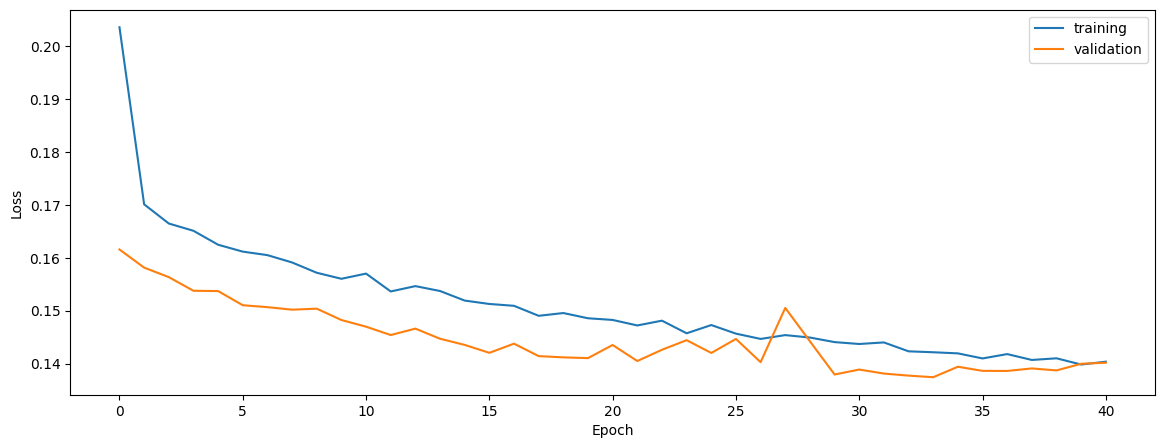

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1t2','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.6674058863791923
0.6689705249569707
0.6277103965795559


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.6631094803751841
0.6604686984266696
0.6212810308887625


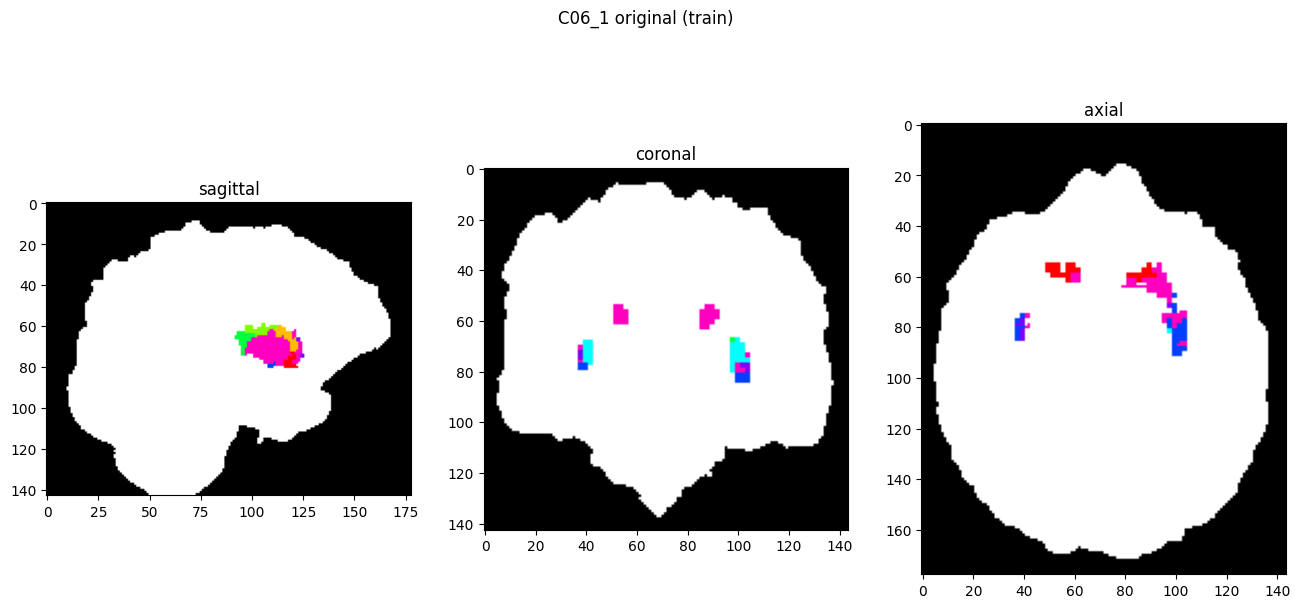

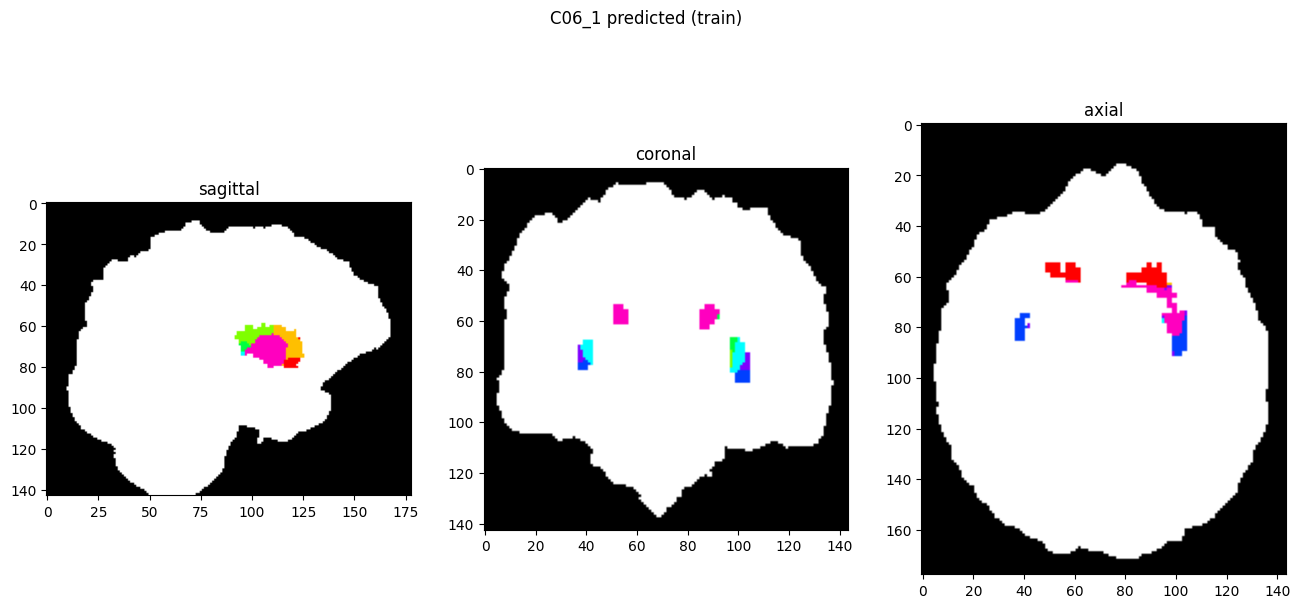

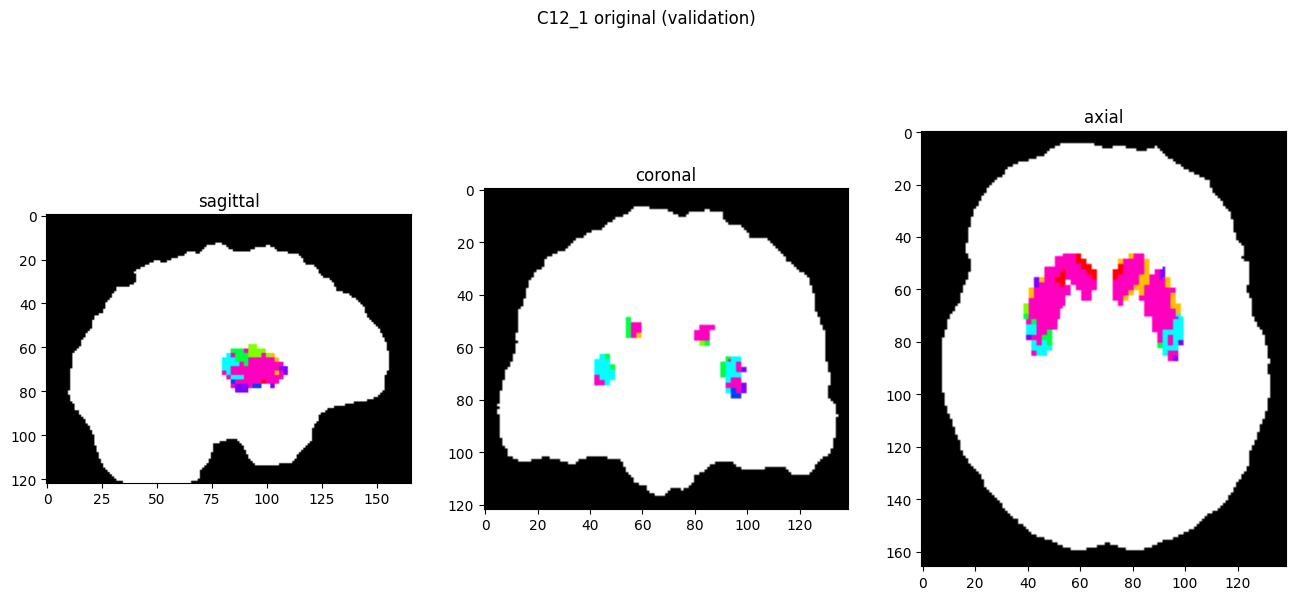

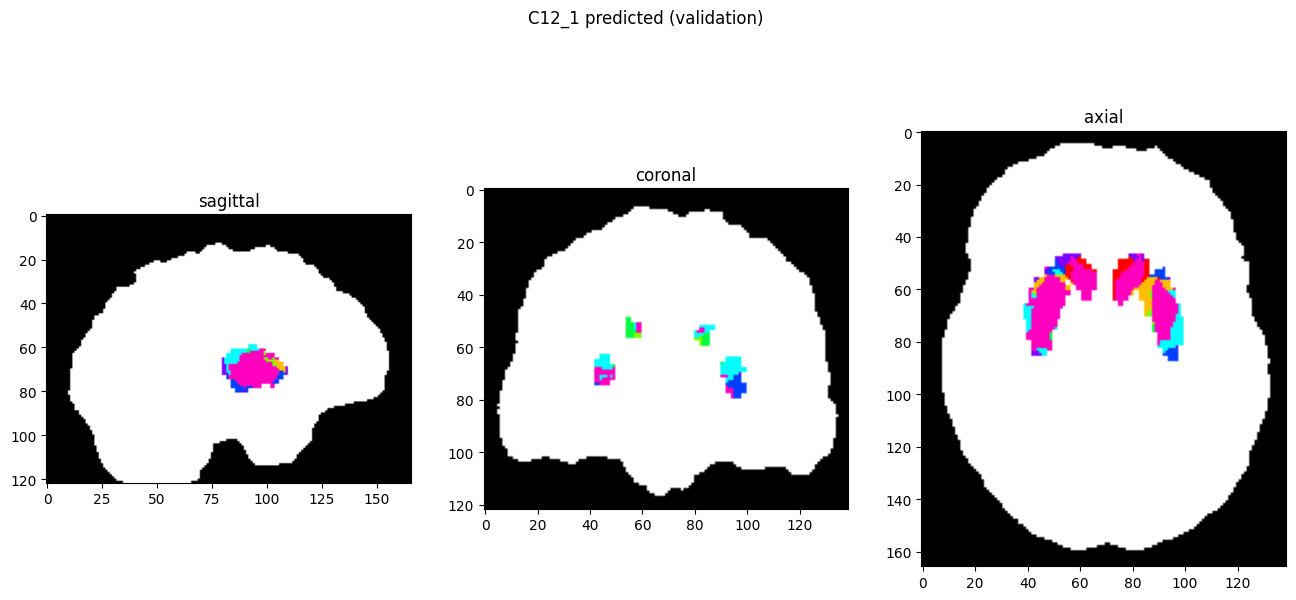

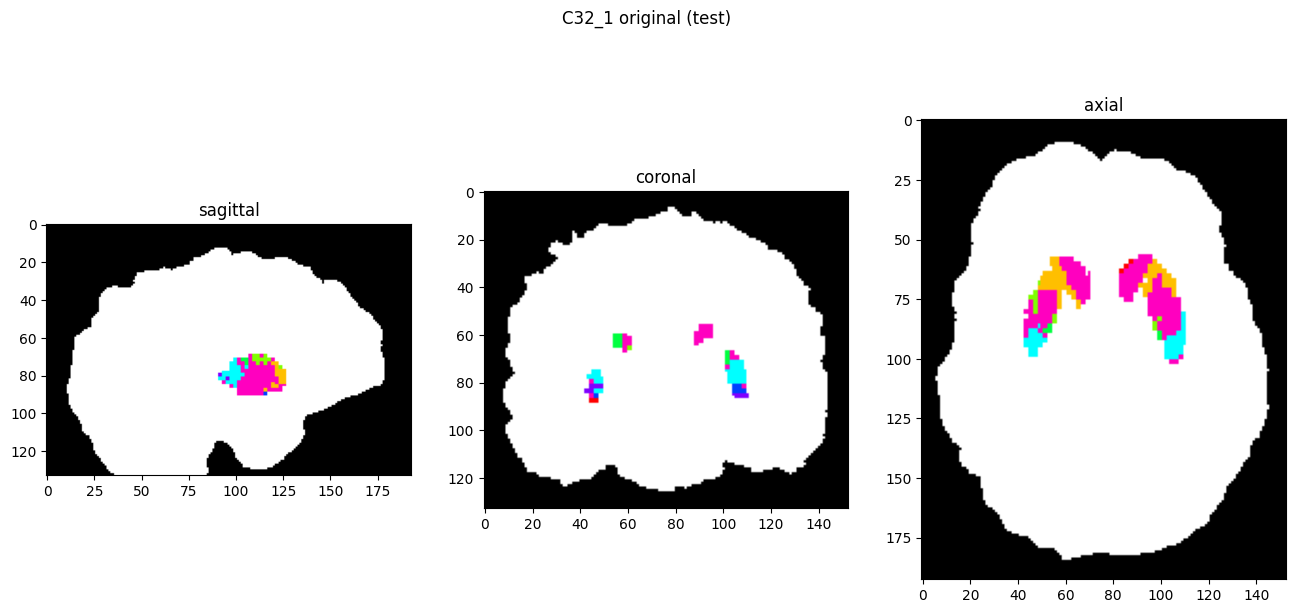

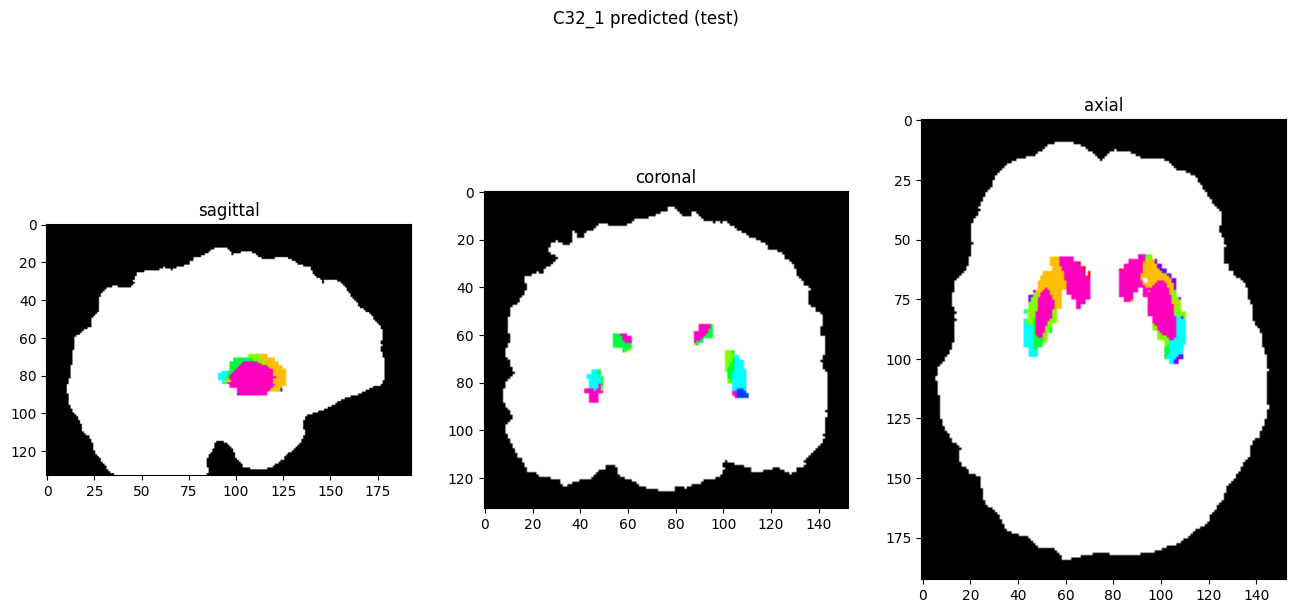

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)